In [156]:
## Experiment prompts from VGG to sam
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import json
from skimage.measure import label, regionprops
import glob
import os
from PIL import Image

In [148]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

def extract_cx_cy(region_shape_attributes):
    attributes = json.loads(region_shape_attributes)
    return attributes['cx'], attributes['cy']


In [135]:
#image = cv2.imread('C:\\Users\\d42684\\Documents\\STAGE\\CODES\\ACtoolbox-main\\Dataset\\Small_ARIS_Mauzac\\TEST\\All_Originals\\2014-11-16_002000_t8_Obj_frame3065.jpg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#2014-11-05_184000_t0_Obj_frame315.jpg
#2014-11-16_002000_t0_Obj_frame508.jpg

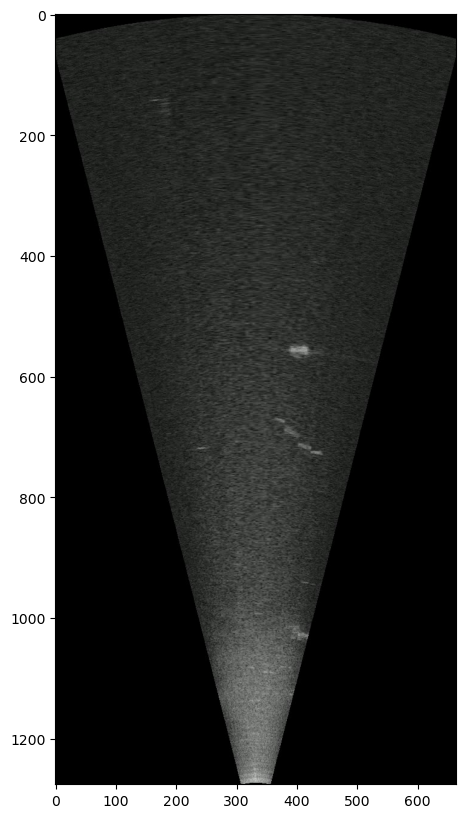

In [136]:
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# plt.axis('on')
# plt.show()


In [144]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "C:\\Users\\d42684\\Documents\\STAGE\\CODES\\segment-anything-main\\sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
#sam.to(device=device)

predictor = SamPredictor(sam)



In [174]:
ImageList = glob.glob(os.path.join('C:\\Users\\d42684\\Documents\\STAGE\\CODES\\ACtoolbox-main\\Dataset\\Small_ARIS_Mauzac\\TEST\\All_Originals\\*.jpg'))

df = pd.read_csv('data.csv')

filtered_df0 = df[df['file_attributes'] != '{"Object_Count":"0"}']

for imagepath in ImageList: # Puedo optimizar al directamente eliminar todos los que tienen region 0

    imageName = imagepath.split('\\')[-1]


    filtered_df = filtered_df0[filtered_df0['filename'] == imageName]

    # Check if filtered_df is empty
    if filtered_df.empty:
        continue  # Skip this iteration if no matches found

    print("File attributes (regions):")
    print(json.loads(filtered_df.iloc[0]['file_attributes'])['Object_Count'])

    RegionsNum = json.loads(filtered_df.iloc[0]['file_attributes'])['Object_Count']


    if int(RegionsNum) == 0: # If there are no prompts for masks continue to next image
        continue

    image = cv2.imread(imagepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    predictor.set_image(image)


    
    print("image atributes: ")
    print(filtered_df["region_shape_attributes"])
    print('-----------------------------------------')
    region_shape_attributes_values = filtered_df['region_shape_attributes'].tolist()
    

    filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))

    cx = filtered_df['cx'].tolist()
    cy = filtered_df['cy'].tolist()
    #print(cx)
    #print(cy)


    #print('PROMPTS IN ARRAY:')
    array = np.column_stack((cx, cy))
    #print(array)

    

    #print('Setting prompts for SAM: ')

    input_point = array
    #print(input_point)
    #print(input_point.shape)
    input_label = np.ones(len(cx))

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,   
    )

    bestscore = 0
    Alternative_bestscore = 0
    Alternative_bestMask = 0
    BestMask = 0

    for i, (mask, score) in enumerate(zip(masks, scores)):

        if np.sum(mask) < 460446*0.5: # mask siwe has to be at lest 25% smaller than the precomputed triangle area, which still a very soft margin

            labeled_image = label(mask)
            regions = regionprops(labeled_image)
            number_of_regions = len(regions) # getting the number of objects in the segmentation
            #print("Number of regions is: ")
            #print(number_of_regions)

            if Alternative_bestscore < score:
                if number_of_regions != int(RegionsNum): ## Maybe I should add an alternative best for cases in which small fishes merge together or eels are cut, and so the number of regions dont match
                    Alternative_bestMask = mask
                    Alternative_bestscore = score
                    continue

            if int(number_of_regions) == int(RegionsNum): # the segmentation has to have the same number of objects as the annotations.
                #if bestscore < score:
                BestMask = mask
                bestscore =score
                break # If a mask matches the region numbers, break
    if bestscore == 0:
        BestMask = Alternative_bestMask
        bestscore = Alternative_bestscore

    #########I could add a closing if there are more regions than normal (eel cut) and opening if there are less (merged fish)#########
    plot = False
    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(BestMask, plt.gca())
        #show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask Score: {bestscore:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()  


        for i, (mask, score) in enumerate(zip(masks, scores)):
            plt.figure(figsize=(10,10))
            plt.imshow(image)
            show_mask(mask, plt.gca())
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
            plt.axis('off')
            plt.show()  


    mask_image = Image.fromarray(BestMask)

    # Save the mask as a JPEG image using PIL
    mask_image.save(os.path.join(r'C:\Users\d42684\Documents\STAGE\CODES\ACtoolbox-main\Dataset\Small_ARIS_Mauzac\TEST\All_Originals\masks',str('m_'+imageName)))
    #np.save(os.path.join(r'C:\Users\d42684\Documents\STAGE\CODES\ACtoolbox-main\Dataset\Small_ARIS_Mauzac\TEST\All_Originals\masks',str('m_'+imageName)), BestMask)


File attributes (regions):
2
image atributes: 
100    {"name":"point","cx":532,"cy":548}
101    {"name":"point","cx":506,"cy":579}
102    {"name":"point","cx":500,"cy":542}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[532, 506, 500]
[548, 579, 542]
PROMPTS IN ARRAY:
[[532 548]
 [506 579]
 [500 542]]
Setting prompts for SAM: 
[[532 548]
 [506 579]
 [500 542]]
(3, 2)
Number of regions is: 
6
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
103    {"name":"point","cx":524,"cy":547}
104    {"name":"point","cx":490,"cy":540}
105    {"name":"point","cx":493,"cy":579}
106    {"name":"point","cx":521,"cy":599}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[524, 490, 493, 521]
[547, 540, 579, 599]
PROMPTS IN ARRAY:
[[524 547]
 [490 540]
 [493 579]
 [521 599]]
Setting prompts for SAM: 
[[524 547]
 [490 540]
 [493 579]
 [521 599]]
(4, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
107    {"name":"point","cx":512,"cy":547}
108    {"name":"point","cx":480,"cy":541}
109    {"name":"point","cx":479,"cy":577}
110    {"name":"point","cx":450,"cy":574}
111    {"name":"point","cx":510,"cy":599}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[512, 480, 479, 450, 510]
[547, 541, 577, 574, 599]
PROMPTS IN ARRAY:
[[512 547]
 [480 541]
 [479 577]
 [450 574]
 [510 599]]
Setting prompts for SAM: 
[[512 547]
 [480 541]
 [479 577]
 [450 574]
 [510 599]]
(5, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
112    {"name":"point","cx":497,"cy":602}
113    {"name":"point","cx":458,"cy":577}
114    {"name":"point","cx":492,"cy":546}
115    {"name":"point","cx":465,"cy":540}
116    {"name":"point","cx":421,"cy":572}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[497, 458, 492, 465, 421]
[602, 577, 546, 540, 572]
PROMPTS IN ARRAY:
[[497 602]
 [458 577]
 [492 546]
 [465 540]
 [421 572]]
Setting prompts for SAM: 
[[497 602]
 [458 577]
 [492 546]
 [465 540]
 [421 572]]
(5, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
3
image atributes: 
117    {"name":"point","cx":480,"cy":602}
118    {"name":"point","cx":451,"cy":578}
119    {"name":"point","cx":490,"cy":544}
120    {"name":"point","cx":451,"cy":538}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[480, 451, 490, 451]
[602, 578, 544, 538]
PROMPTS IN ARRAY:
[[480 602]
 [451 578]
 [490 544]
 [451 538]]
Setting prompts for SAM: 
[[480 602]
 [451 578]
 [490 544]
 [451 538]]
(4, 2)
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
121    {"name":"point","cx":434,"cy":575}
122    {"name":"point","cx":474,"cy":543}
123    {"name":"point","cx":449,"cy":539}
124    {"name":"point","cx":477,"cy":602}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[434, 474, 449, 477]
[575, 543, 539, 602]
PROMPTS IN ARRAY:
[[434 575]
 [474 543]
 [449 539]
 [477 602]]
Setting prompts for SAM: 
[[434 575]
 [474 543]
 [449 539]
 [477 602]]
(4, 2)
Number of regions is: 
5
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
125    {"name":"point","cx":423,"cy":573}
126    {"name":"point","cx":396,"cy":572}
127    {"name":"point","cx":464,"cy":541}
128    {"name":"point","cx":434,"cy":536}
129    {"name":"point","cx":463,"cy":602}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[423, 396, 464, 434, 463]
[573, 572, 541, 536, 602]
PROMPTS IN ARRAY:
[[423 573]
 [396 572]
 [464 541]
 [434 536]
 [463 602]]
Setting prompts for SAM: 
[[423 573]
 [396 572]
 [464 541]
 [434 536]
 [463 602]]
(5, 2)
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
130    {"name":"point","cx":458,"cy":540}
131    {"name":"point","cx":429,"cy":535}
132    {"name":"point","cx":418,"cy":575}
133    {"name":"point","cx":453,"cy":605}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[458, 429, 418, 453]
[540, 535, 575, 605]
PROMPTS IN ARRAY:
[[458 540]
 [429 535]
 [418 575]
 [453 605]]
Setting prompts for SAM: 
[[458 540]
 [429 535]
 [418 575]
 [453 605]]
(4, 2)
Number of regions is: 
7
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
134    {"name":"point","cx":445,"cy":538}
135    {"name":"point","cx":419,"cy":538}
136    {"name":"point","cx":410,"cy":574}
137    {"name":"point","cx":381,"cy":572}
138    {"name":"point","cx":436,"cy":610}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[445, 419, 410, 381, 436]
[538, 538, 574, 572, 610]
PROMPTS IN ARRAY:
[[445 538]
 [419 538]
 [410 574]
 [381 572]
 [436 610]]
Setting prompts for SAM: 
[[445 538]
 [419 538]
 [410 574]
 [381 572]
 [436 610]]
(5, 2)
Number of regions is: 
10
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
139    {"name":"point","cx":424,"cy":609}
140    {"name":"point","cx":400,"cy":562}
141    {"name":"point","cx":397,"cy":570}
142    {"name":"point","cx":404,"cy":574}
143    {"name":"point","cx":373,"cy":572}
144    {"name":"point","cx":436,"cy":540}
145    {"name":"point","cx":414,"cy":533}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[424, 400, 397, 404, 373, 436, 414]
[609, 562, 570, 574, 572, 540, 533]
PROMPTS IN ARRAY:
[[424 609]
 [400 562]
 [397 570]
 [404 574]
 [373 572]
 [436 540]
 [414 533]]
Setting prompts for SAM: 
[[424 609]
 [400 562]
 [397 570]
 [404 574]
 [373 572]
 [436 540]
 [414 533]]
(7, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
146    {"name":"point","cx":380,"cy":563}
147    {"name":"point","cx":379,"cy":574}
148    {"name":"point","cx":355,"cy":572}
149    {"name":"point","cx":418,"cy":540}
150    {"name":"point","cx":402,"cy":616}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[380, 379, 355, 418, 402]
[563, 574, 572, 540, 616]
PROMPTS IN ARRAY:
[[380 563]
 [379 574]
 [355 572]
 [418 540]
 [402 616]]
Setting prompts for SAM: 
[[380 563]
 [379 574]
 [355 572]
 [418 540]
 [402 616]]
(5, 2)
Number of regions is: 
7


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
3
image atributes: 
151    {"name":"point","cx":402,"cy":540}
152    {"name":"point","cx":414,"cy":533}
153    {"name":"point","cx":374,"cy":572}
154    {"name":"point","cx":357,"cy":565}
155    {"name":"point","cx":393,"cy":619}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[402, 414, 374, 357, 393]
[540, 533, 572, 565, 619]
PROMPTS IN ARRAY:
[[402 540]
 [414 533]
 [374 572]
 [357 565]
 [393 619]]
Setting prompts for SAM: 
[[402 540]
 [414 533]
 [374 572]
 [357 565]
 [393 619]]
(5, 2)
Number of regions is: 
4
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
3
image atributes: 
156    {"name":"point","cx":394,"cy":542}
157    {"name":"point","cx":409,"cy":531}
158    {"name":"point","cx":366,"cy":575}
159    {"name":"point","cx":380,"cy":619}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[394, 409, 366, 380]
[542, 531, 575, 619]
PROMPTS IN ARRAY:
[[394 542]
 [409 531]
 [366 575]
 [380 619]]
Setting prompts for SAM: 
[[394 542]
 [409 531]
 [366 575]
 [380 619]]
(4, 2)
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
160    {"name":"point","cx":380,"cy":541}
161    {"name":"point","cx":391,"cy":531}
162    {"name":"point","cx":353,"cy":572}
163    {"name":"point","cx":371,"cy":617}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[380, 391, 353, 371]
[541, 531, 572, 617]
PROMPTS IN ARRAY:
[[380 541]
 [391 531]
 [353 572]
 [371 617]]
Setting prompts for SAM: 
[[380 541]
 [391 531]
 [353 572]
 [371 617]]
(4, 2)
Number of regions is: 
5
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
164    {"name":"point","cx":371,"cy":543}
165    {"name":"point","cx":388,"cy":529}
166    {"name":"point","cx":348,"cy":572}
167    {"name":"point","cx":365,"cy":622}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[371, 388, 348, 365]
[543, 529, 572, 622]
PROMPTS IN ARRAY:
[[371 543]
 [388 529]
 [348 572]
 [365 622]]
Setting prompts for SAM: 
[[371 543]
 [388 529]
 [348 572]
 [365 622]]
(4, 2)
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
168    {"name":"point","cx":351,"cy":624}
169    {"name":"point","cx":341,"cy":574}
170    {"name":"point","cx":341,"cy":567}
171    {"name":"point","cx":364,"cy":541}
172    {"name":"point","cx":380,"cy":517}
173    {"name":"point","cx":380,"cy":529}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[351, 341, 341, 364, 380, 380]
[624, 574, 567, 541, 517, 529]
PROMPTS IN ARRAY:
[[351 624]
 [341 574]
 [341 567]
 [364 541]
 [380 517]
 [380 529]]
Setting prompts for SAM: 
[[351 624]
 [341 574]
 [341 567]
 [364 541]
 [380 517]
 [380 529]]
(6, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
174    {"name":"point","cx":352,"cy":545}
175    {"name":"point","cx":368,"cy":528}
176    {"name":"point","cx":333,"cy":572}
177    {"name":"point","cx":341,"cy":624}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[352, 368, 333, 341]
[545, 528, 572, 624]
PROMPTS IN ARRAY:
[[352 545]
 [368 528]
 [333 572]
 [341 624]]
Setting prompts for SAM: 
[[352 545]
 [368 528]
 [333 572]
 [341 624]]
(4, 2)
Number of regions is: 
4
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
178    {"name":"point","cx":358,"cy":532}
179    {"name":"point","cx":348,"cy":541}
180    {"name":"point","cx":337,"cy":543}
181    {"name":"point","cx":319,"cy":570}
182    {"name":"point","cx":336,"cy":625}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[358, 348, 337, 319, 336]
[532, 541, 543, 570, 625]
PROMPTS IN ARRAY:
[[358 532]
 [348 541]
 [337 543]
 [319 570]
 [336 625]]
Setting prompts for SAM: 
[[358 532]
 [348 541]
 [337 543]
 [319 570]
 [336 625]]
(5, 2)
Number of regions is: 
2
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
277    {"name":"point","cx":651,"cy":62}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[651]
[62]
PROMPTS IN ARRAY:
[[651  62]]
Setting prompts for SAM: 
[[651  62]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
278    {"name":"point","cx":645,"cy":60}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[645]
[60]
PROMPTS IN ARRAY:
[[645  60]]
Setting prompts for SAM: 
[[645  60]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
279    {"name":"point","cx":640,"cy":64}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[640]
[64]
PROMPTS IN ARRAY:
[[640  64]]
Setting prompts for SAM: 
[[640  64]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
280    {"name":"point","cx":627,"cy":58}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[627]
[58]
PROMPTS IN ARRAY:
[[627  58]]
Setting prompts for SAM: 
[[627  58]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
281    {"name":"point","cx":614,"cy":54}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[614]
[54]
PROMPTS IN ARRAY:
[[614  54]]
Setting prompts for SAM: 
[[614  54]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
282    {"name":"point","cx":611,"cy":55}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[611]
[55]
PROMPTS IN ARRAY:
[[611  55]]
Setting prompts for SAM: 
[[611  55]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
283    {"name":"point","cx":575,"cy":45}
284    {"name":"point","cx":614,"cy":62}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[575, 614]
[45, 62]
PROMPTS IN ARRAY:
[[575  45]
 [614  62]]
Setting prompts for SAM: 
[[575  45]
 [614  62]]
(2, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
2
image atributes: 
285    {"name":"point","cx":575,"cy":47}
286    {"name":"point","cx":607,"cy":61}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[575, 607]
[47, 61]
PROMPTS IN ARRAY:
[[575  47]
 [607  61]]
Setting prompts for SAM: 
[[575  47]
 [607  61]]
(2, 2)
Number of regions is: 
1
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
2
image atributes: 
287    {"name":"point","cx":568,"cy":47}
288    {"name":"point","cx":600,"cy":62}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[568, 600]
[47, 62]
PROMPTS IN ARRAY:
[[568  47]
 [600  62]]
Setting prompts for SAM: 
[[568  47]
 [600  62]]
(2, 2)
Number of regions is: 
1
Number of regions is: 
1
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
289    {"name":"point","cx":556,"cy":43}
290    {"name":"point","cx":586,"cy":52}
291    {"name":"point","cx":615,"cy":33}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[556, 586, 615]
[43, 52, 33]
PROMPTS IN ARRAY:
[[556  43]
 [586  52]
 [615  33]]
Setting prompts for SAM: 
[[556  43]
 [586  52]
 [615  33]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
292    {"name":"point","cx":547,"cy":42}
293    {"name":"point","cx":578,"cy":50}
294    {"name":"point","cx":612,"cy":33}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[547, 578, 612]
[42, 50, 33]
PROMPTS IN ARRAY:
[[547  42]
 [578  50]
 [612  33]]
Setting prompts for SAM: 
[[547  42]
 [578  50]
 [612  33]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
295    {"name":"point","cx":536,"cy":42}
296    {"name":"point","cx":567,"cy":49}
297    {"name":"point","cx":594,"cy":33}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[536, 567, 594]
[42, 49, 33]
PROMPTS IN ARRAY:
[[536  42]
 [567  49]
 [594  33]]
Setting prompts for SAM: 
[[536  42]
 [567  49]
 [594  33]]
(3, 2)
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
298    {"name":"point","cx":562,"cy":48}
299    {"name":"point","cx":582,"cy":30}
300    {"name":"point","cx":525,"cy":41}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[562, 582, 525]
[48, 30, 41]
PROMPTS IN ARRAY:
[[562  48]
 [582  30]
 [525  41]]
Setting prompts for SAM: 
[[562  48]
 [582  30]
 [525  41]]
(3, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
2
File attributes (regions):
3
image atributes: 
301    {"name":"point","cx":514,"cy":43}
302    {"name":"point","cx":545,"cy":46}
303    {"name":"point","cx":575,"cy":31}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[514, 545, 575]
[43, 46, 31]
PROMPTS IN ARRAY:
[[514  43]
 [545  46]
 [575  31]]
Setting prompts for SAM: 
[[514  43]
 [545  46]
 [575  31]]
(3, 2)
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
304    {"name":"point","cx":503,"cy":45}
305    {"name":"point","cx":542,"cy":46}
306    {"name":"point","cx":564,"cy":31}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[503, 542, 564]
[45, 46, 31]
PROMPTS IN ARRAY:
[[503  45]
 [542  46]
 [564  31]]
Setting prompts for SAM: 
[[503  45]
 [542  46]
 [564  31]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
307    {"name":"point","cx":482,"cy":48}
308    {"name":"point","cx":524,"cy":41}
309    {"name":"point","cx":540,"cy":30}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[482, 524, 540]
[48, 41, 30]
PROMPTS IN ARRAY:
[[482  48]
 [524  41]
 [540  30]]
Setting prompts for SAM: 
[[482  48]
 [524  41]
 [540  30]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
310    {"name":"point","cx":477,"cy":50}
311    {"name":"point","cx":516,"cy":42}
312    {"name":"point","cx":534,"cy":30}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[477, 516, 534]
[50, 42, 30]
PROMPTS IN ARRAY:
[[477  50]
 [516  42]
 [534  30]]
Setting prompts for SAM: 
[[477  50]
 [516  42]
 [534  30]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
1
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
313    {"name":"point","cx":465,"cy":53}
314    {"name":"point","cx":507,"cy":42}
315    {"name":"point","cx":526,"cy":31}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[465, 507, 526]
[53, 42, 31]
PROMPTS IN ARRAY:
[[465  53]
 [507  42]
 [526  31]]
Setting prompts for SAM: 
[[465  53]
 [507  42]
 [526  31]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
316    {"name":"point","cx":455,"cy":53}
317    {"name":"point","cx":495,"cy":39}
318    {"name":"point","cx":513,"cy":28}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[455, 495, 513]
[53, 39, 28]
PROMPTS IN ARRAY:
[[455  53]
 [495  39]
 [513  28]]
Setting prompts for SAM: 
[[455  53]
 [495  39]
 [513  28]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
319    {"name":"point","cx":446,"cy":59}
320    {"name":"point","cx":485,"cy":40}
321    {"name":"point","cx":507,"cy":31}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[446, 485, 507]
[59, 40, 31]
PROMPTS IN ARRAY:
[[446  59]
 [485  40]
 [507  31]]
Setting prompts for SAM: 
[[446  59]
 [485  40]
 [507  31]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
1
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
322    {"name":"point","cx":435,"cy":58}
323    {"name":"point","cx":483,"cy":44}
324    {"name":"point","cx":498,"cy":31}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[435, 483, 498]
[58, 44, 31]
PROMPTS IN ARRAY:
[[435  58]
 [483  44]
 [498  31]]
Setting prompts for SAM: 
[[435  58]
 [483  44]
 [498  31]]
(3, 2)
Number of regions is: 
1
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
3
image atributes: 
325    {"name":"point","cx":433,"cy":58}
326    {"name":"point","cx":465,"cy":41}
327    {"name":"point","cx":481,"cy":42}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[433, 465, 481]
[58, 41, 42]
PROMPTS IN ARRAY:
[[433  58]
 [465  41]
 [481  42]]
Setting prompts for SAM: 
[[433  58]
 [465  41]
 [481  42]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
328    {"name":"point","cx":416,"cy":63}
329    {"name":"point","cx":449,"cy":41}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[416, 449]
[63, 41]
PROMPTS IN ARRAY:
[[416  63]
 [449  41]]
Setting prompts for SAM: 
[[416  63]
 [449  41]]
(2, 2)
Number of regions is: 
1
Number of regions is: 
1
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
330    {"name":"point","cx":402,"cy":64}
331    {"name":"point","cx":434,"cy":43}
332    {"name":"point","cx":458,"cy":58}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[402, 434, 458]
[64, 43, 58]
PROMPTS IN ARRAY:
[[402  64]
 [434  43]
 [458  58]]
Setting prompts for SAM: 
[[402  64]
 [434  43]
 [458  58]]
(3, 2)
Number of regions is: 
1
Number of regions is: 
1
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
333    {"name":"point","cx":389,"cy":65}
334    {"name":"point","cx":423,"cy":41}
335    {"name":"point","cx":449,"cy":59}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[389, 423, 449]
[65, 41, 59]
PROMPTS IN ARRAY:
[[389  65]
 [423  41]
 [449  59]]
Setting prompts for SAM: 
[[389  65]
 [423  41]
 [449  59]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
336    {"name":"point","cx":383,"cy":67}
337    {"name":"point","cx":407,"cy":41}
338    {"name":"point","cx":436,"cy":66}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[383, 407, 436]
[67, 41, 66]
PROMPTS IN ARRAY:
[[383  67]
 [407  41]
 [436  66]]
Setting prompts for SAM: 
[[383  67]
 [407  41]
 [436  66]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
339    {"name":"point","cx":374,"cy":68}
340    {"name":"point","cx":402,"cy":42}
341    {"name":"point","cx":429,"cy":67}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[374, 402, 429]
[68, 42, 67]
PROMPTS IN ARRAY:
[[374  68]
 [402  42]
 [429  67]]
Setting prompts for SAM: 
[[374  68]
 [402  42]
 [429  67]]
(3, 2)
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
342    {"name":"point","cx":361,"cy":71}
343    {"name":"point","cx":394,"cy":41}
344    {"name":"point","cx":426,"cy":65}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[361, 394, 426]
[71, 41, 65]
PROMPTS IN ARRAY:
[[361  71]
 [394  41]
 [426  65]]
Setting prompts for SAM: 
[[361  71]
 [394  41]
 [426  65]]
(3, 2)
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
345    {"name":"point","cx":358,"cy":74}
346    {"name":"point","cx":382,"cy":40}
347    {"name":"point","cx":416,"cy":70}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[358, 382, 416]
[74, 40, 70]
PROMPTS IN ARRAY:
[[358  74]
 [382  40]
 [416  70]]
Setting prompts for SAM: 
[[358  74]
 [382  40]
 [416  70]]
(3, 2)
Number of regions is: 
4
Number of regions is: 
1
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
348    {"name":"point","cx":348,"cy":75}
349    {"name":"point","cx":375,"cy":42}
350    {"name":"point","cx":404,"cy":72}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[348, 375, 404]
[75, 42, 72]
PROMPTS IN ARRAY:
[[348  75]
 [375  42]
 [404  72]]
Setting prompts for SAM: 
[[348  75]
 [375  42]
 [404  72]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
351    {"name":"point","cx":334,"cy":79}
352    {"name":"point","cx":365,"cy":43}
353    {"name":"point","cx":394,"cy":76}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[334, 365, 394]
[79, 43, 76]
PROMPTS IN ARRAY:
[[334  79]
 [365  43]
 [394  76]]
Setting prompts for SAM: 
[[334  79]
 [365  43]
 [394  76]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
354    {"name":"point","cx":333,"cy":76}
355    {"name":"point","cx":356,"cy":42}
356    {"name":"point","cx":389,"cy":76}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[333, 356, 389]
[76, 42, 76]
PROMPTS IN ARRAY:
[[333  76]
 [356  42]
 [389  76]]
Setting prompts for SAM: 
[[333  76]
 [356  42]
 [389  76]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
357    {"name":"point","cx":314,"cy":79}
358    {"name":"point","cx":338,"cy":41}
359    {"name":"point","cx":369,"cy":81}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[314, 338, 369]
[79, 41, 81]
PROMPTS IN ARRAY:
[[314  79]
 [338  41]
 [369  81]]
Setting prompts for SAM: 
[[314  79]
 [338  41]
 [369  81]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
360    {"name":"point","cx":300,"cy":81}
361    {"name":"point","cx":319,"cy":43}
362    {"name":"point","cx":352,"cy":89}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[300, 319, 352]
[81, 43, 89]
PROMPTS IN ARRAY:
[[300  81]
 [319  43]
 [352  89]]
Setting prompts for SAM: 
[[300  81]
 [319  43]
 [352  89]]
(3, 2)
Number of regions is: 
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
3
image atributes: 
363    {"name":"point","cx":294,"cy":84}
364    {"name":"point","cx":320,"cy":42}
365    {"name":"point","cx":343,"cy":91}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[294, 320, 343]
[84, 42, 91]
PROMPTS IN ARRAY:
[[294  84]
 [320  42]
 [343  91]]
Setting prompts for SAM: 
[[294  84]
 [320  42]
 [343  91]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
366    {"name":"point","cx":287,"cy":84}
367    {"name":"point","cx":311,"cy":42}
368    {"name":"point","cx":335,"cy":93}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[287, 311, 335]
[84, 42, 93]
PROMPTS IN ARRAY:
[[287  84]
 [311  42]
 [335  93]]
Setting prompts for SAM: 
[[287  84]
 [311  42]
 [335  93]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
369    {"name":"point","cx":294,"cy":41}
370    {"name":"point","cx":277,"cy":86}
371    {"name":"point","cx":325,"cy":94}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[294, 277, 325]
[41, 86, 94]
PROMPTS IN ARRAY:
[[294  41]
 [277  86]
 [325  94]]
Setting prompts for SAM: 
[[294  41]
 [277  86]
 [325  94]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
372    {"name":"point","cx":257,"cy":91}
373    {"name":"point","cx":269,"cy":40}
374    {"name":"point","cx":302,"cy":97}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[257, 269, 302]
[91, 40, 97]
PROMPTS IN ARRAY:
[[257  91]
 [269  40]
 [302  97]]
Setting prompts for SAM: 
[[257  91]
 [269  40]
 [302  97]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
375    {"name":"point","cx":249,"cy":92}
376    {"name":"point","cx":263,"cy":38}
377    {"name":"point","cx":285,"cy":99}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[249, 263, 285]
[92, 38, 99]
PROMPTS IN ARRAY:
[[249  92]
 [263  38]
 [285  99]]
Setting prompts for SAM: 
[[249  92]
 [263  38]
 [285  99]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
378     {"name":"point","cx":250,"cy":38}
379     {"name":"point","cx":237,"cy":95}
380    {"name":"point","cx":282,"cy":101}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[250, 237, 282]
[38, 95, 101]
PROMPTS IN ARRAY:
[[250  38]
 [237  95]
 [282 101]]
Setting prompts for SAM: 
[[250  38]
 [237  95]
 [282 101]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
3
image atributes: 
381    {"name":"point","cx":231,"cy":100}
382    {"name":"point","cx":270,"cy":100}
383     {"name":"point","cx":240,"cy":36}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[231, 270, 240]
[100, 100, 36]
PROMPTS IN ARRAY:
[[231 100]
 [270 100]
 [240  36]]
Setting prompts for SAM: 
[[231 100]
 [270 100]
 [240  36]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
384     {"name":"point","cx":230,"cy":35}
385    {"name":"point","cx":223,"cy":109}
386    {"name":"point","cx":265,"cy":102}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[230, 223, 265]
[35, 109, 102]
PROMPTS IN ARRAY:
[[230  35]
 [223 109]
 [265 102]]
Setting prompts for SAM: 
[[230  35]
 [223 109]
 [265 102]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
387    {"name":"point","cx":211,"cy":112}
388    {"name":"point","cx":256,"cy":103}
389     {"name":"point","cx":228,"cy":33}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[211, 256, 228]
[112, 103, 33]
PROMPTS IN ARRAY:
[[211 112]
 [256 103]
 [228  33]]
Setting prompts for SAM: 
[[211 112]
 [256 103]
 [228  33]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
3
image atributes: 
390     {"name":"point","cx":216,"cy":33}
391    {"name":"point","cx":204,"cy":117}
392    {"name":"point","cx":243,"cy":107}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[216, 204, 243]
[33, 117, 107]
PROMPTS IN ARRAY:
[[216  33]
 [204 117]
 [243 107]]
Setting prompts for SAM: 
[[216  33]
 [204 117]
 [243 107]]
(3, 2)
Number of regions is: 
3
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
393    {"name":"point","cx":201,"cy":117}
394    {"name":"point","cx":242,"cy":103}
395     {"name":"point","cx":209,"cy":31}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[201, 242, 209]
[117, 103, 31]
PROMPTS IN ARRAY:
[[201 117]
 [242 103]
 [209  31]]
Setting prompts for SAM: 
[[201 117]
 [242 103]
 [209  31]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
396     {"name":"point","cx":205,"cy":29}
397    {"name":"point","cx":196,"cy":116}
398    {"name":"point","cx":232,"cy":103}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[205, 196, 232]
[29, 116, 103]
PROMPTS IN ARRAY:
[[205  29]
 [196 116]
 [232 103]]
Setting prompts for SAM: 
[[205  29]
 [196 116]
 [232 103]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
399    {"name":"point","cx":224,"cy":107}
400    {"name":"point","cx":185,"cy":125}
401     {"name":"point","cx":189,"cy":28}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[224, 185, 189]
[107, 125, 28]
PROMPTS IN ARRAY:
[[224 107]
 [185 125]
 [189  28]]
Setting prompts for SAM: 
[[224 107]
 [185 125]
 [189  28]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
3
image atributes: 
402    {"name":"point","cx":180,"cy":128}
403    {"name":"point","cx":217,"cy":106}
404     {"name":"point","cx":187,"cy":30}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[180, 217, 187]
[128, 106, 30]
PROMPTS IN ARRAY:
[[180 128]
 [217 106]
 [187  30]]
Setting prompts for SAM: 
[[180 128]
 [217 106]
 [187  30]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
405    {"name":"point","cx":165,"cy":132}
406    {"name":"point","cx":201,"cy":113}
407     {"name":"point","cx":174,"cy":26}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[165, 201, 174]
[132, 113, 26]
PROMPTS IN ARRAY:
[[165 132]
 [201 113]
 [174  26]]
Setting prompts for SAM: 
[[165 132]
 [201 113]
 [174  26]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
3
image atributes: 
408    {"name":"point","cx":157,"cy":139}
409    {"name":"point","cx":194,"cy":111}
410     {"name":"point","cx":165,"cy":25}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[157, 194, 165]
[139, 111, 25]
PROMPTS IN ARRAY:
[[157 139]
 [194 111]
 [165  25]]
Setting prompts for SAM: 
[[157 139]
 [194 111]
 [165  25]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
411    {"name":"point","cx":187,"cy":116}
412    {"name":"point","cx":152,"cy":136}
413     {"name":"point","cx":155,"cy":26}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[187, 152, 155]
[116, 136, 26]
PROMPTS IN ARRAY:
[[187 116]
 [152 136]
 [155  26]]
Setting prompts for SAM: 
[[187 116]
 [152 136]
 [155  26]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
414    {"name":"point","cx":145,"cy":145}
415    {"name":"point","cx":179,"cy":117}
416     {"name":"point","cx":142,"cy":24}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[145, 179, 142]
[145, 117, 24]
PROMPTS IN ARRAY:
[[145 145]
 [179 117]
 [142  24]]
Setting prompts for SAM: 
[[145 145]
 [179 117]
 [142  24]]
(3, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
2
Number of regions is: 
2
File attributes (regions):
3
image atributes: 
417     {"name":"point","cx":134,"cy":23}
418    {"name":"point","cx":135,"cy":145}
419    {"name":"point","cx":168,"cy":122}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[134, 135, 168]
[23, 145, 122]
PROMPTS IN ARRAY:
[[134  23]
 [135 145]
 [168 122]]
Setting prompts for SAM: 
[[134  23]
 [135 145]
 [168 122]]
(3, 2)
Number of regions is: 
4
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
420    {"name":"point","cx":132,"cy":147}
421    {"name":"point","cx":166,"cy":123}
422     {"name":"point","cx":125,"cy":24}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[132, 166, 125]
[147, 123, 24]
PROMPTS IN ARRAY:
[[132 147]
 [166 123]
 [125  24]]
Setting prompts for SAM: 
[[132 147]
 [166 123]
 [125  24]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
423    {"name":"point","cx":118,"cy":148}
424    {"name":"point","cx":155,"cy":123}
425     {"name":"point","cx":119,"cy":23}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[118, 155, 119]
[148, 123, 23]
PROMPTS IN ARRAY:
[[118 148]
 [155 123]
 [119  23]]
Setting prompts for SAM: 
[[118 148]
 [155 123]
 [119  23]]
(3, 2)
Number of regions is: 
4
Number of regions is: 
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
3
image atributes: 
426    {"name":"point","cx":103,"cy":152}
427    {"name":"point","cx":142,"cy":123}
428     {"name":"point","cx":101,"cy":21}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[103, 142, 101]
[152, 123, 21]
PROMPTS IN ARRAY:
[[103 152]
 [142 123]
 [101  21]]
Setting prompts for SAM: 
[[103 152]
 [142 123]
 [101  21]]
(3, 2)
Number of regions is: 
5
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
429     {"name":"point","cx":96,"cy":153}
430    {"name":"point","cx":134,"cy":123}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[96, 134]
[153, 123]
PROMPTS IN ARRAY:
[[ 96 153]
 [134 123]]
Setting prompts for SAM: 
[[ 96 153]
 [134 123]]
(2, 2)
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
2
image atributes: 
431    {"name":"point","cx":128,"cy":123}
432     {"name":"point","cx":80,"cy":153}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[128, 80]
[123, 153]
PROMPTS IN ARRAY:
[[128 123]
 [ 80 153]]
Setting prompts for SAM: 
[[128 123]
 [ 80 153]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
433    {"name":"point","cx":121,"cy":123}
434     {"name":"point","cx":74,"cy":154}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[121, 74]
[123, 154]
PROMPTS IN ARRAY:
[[121 123]
 [ 74 154]]
Setting prompts for SAM: 
[[121 123]
 [ 74 154]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
435    {"name":"point","cx":58,"cy":155}
436    {"name":"point","cx":99,"cy":119}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[58, 99]
[155, 119]
PROMPTS IN ARRAY:
[[ 58 155]
 [ 99 119]]
Setting prompts for SAM: 
[[ 58 155]
 [ 99 119]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
437    {"name":"point","cx":465,"cy":92}
438    {"name":"point","cx":527,"cy":67}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[465, 527]
[92, 67]
PROMPTS IN ARRAY:
[[465  92]
 [527  67]]
Setting prompts for SAM: 
[[465  92]
 [527  67]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
439    {"name":"point","cx":512,"cy":61}
440    {"name":"point","cx":457,"cy":87}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[512, 457]
[61, 87]
PROMPTS IN ARRAY:
[[512  61]
 [457  87]]
Setting prompts for SAM: 
[[512  61]
 [457  87]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
441    {"name":"point","cx":504,"cy":63}
442    {"name":"point","cx":451,"cy":88}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[504, 451]
[63, 88]
PROMPTS IN ARRAY:
[[504  63]
 [451  88]]
Setting prompts for SAM: 
[[504  63]
 [451  88]]
(2, 2)
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
2
image atributes: 
443    {"name":"point","cx":430,"cy":86}
444    {"name":"point","cx":477,"cy":60}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[430, 477]
[86, 60]
PROMPTS IN ARRAY:
[[430  86]
 [477  60]]
Setting prompts for SAM: 
[[430  86]
 [477  60]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
445    {"name":"point","cx":467,"cy":54}
446    {"name":"point","cx":412,"cy":78}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[467, 412]
[54, 78]
PROMPTS IN ARRAY:
[[467  54]
 [412  78]]
Setting prompts for SAM: 
[[467  54]
 [412  78]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
447    {"name":"point","cx":403,"cy":76}
448    {"name":"point","cx":457,"cy":51}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[403, 457]
[76, 51]
PROMPTS IN ARRAY:
[[403  76]
 [457  51]]
Setting prompts for SAM: 
[[403  76]
 [457  51]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
449    {"name":"point","cx":394,"cy":75}
450    {"name":"point","cx":438,"cy":48}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[394, 438]
[75, 48]
PROMPTS IN ARRAY:
[[394  75]
 [438  48]]
Setting prompts for SAM: 
[[394  75]
 [438  48]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
451    {"name":"point","cx":433,"cy":48}
452    {"name":"point","cx":387,"cy":74}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[433, 387]
[48, 74]
PROMPTS IN ARRAY:
[[433  48]
 [387  74]]
Setting prompts for SAM: 
[[433  48]
 [387  74]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
453    {"name":"point","cx":424,"cy":45}
454    {"name":"point","cx":381,"cy":72}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[424, 381]
[45, 72]
PROMPTS IN ARRAY:
[[424  45]
 [381  72]]
Setting prompts for SAM: 
[[424  45]
 [381  72]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
455    {"name":"point","cx":369,"cy":69}
456    {"name":"point","cx":414,"cy":39}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[369, 414]
[69, 39]
PROMPTS IN ARRAY:
[[369  69]
 [414  39]]
Setting prompts for SAM: 
[[369  69]
 [414  39]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
457    {"name":"point","cx":402,"cy":42}
458    {"name":"point","cx":359,"cy":69}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[402, 359]
[42, 69]
PROMPTS IN ARRAY:
[[402  42]
 [359  69]]
Setting prompts for SAM: 
[[402  42]
 [359  69]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
459    {"name":"point","cx":349,"cy":67}
460    {"name":"point","cx":393,"cy":36}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[349, 393]
[67, 36]
PROMPTS IN ARRAY:
[[349  67]
 [393  36]]
Setting prompts for SAM: 
[[349  67]
 [393  36]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
461    {"name":"point","cx":387,"cy":36}
462    {"name":"point","cx":338,"cy":64}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[387, 338]
[36, 64]
PROMPTS IN ARRAY:
[[387  36]
 [338  64]]
Setting prompts for SAM: 
[[387  36]
 [338  64]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
463    {"name":"point","cx":329,"cy":62}
464    {"name":"point","cx":380,"cy":36}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[329, 380]
[62, 36]
PROMPTS IN ARRAY:
[[329  62]
 [380  36]]
Setting prompts for SAM: 
[[329  62]
 [380  36]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
465    {"name":"point","cx":368,"cy":31}
466    {"name":"point","cx":315,"cy":59}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[368, 315]
[31, 59]
PROMPTS IN ARRAY:
[[368  31]
 [315  59]]
Setting prompts for SAM: 
[[368  31]
 [315  59]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
467    {"name":"point","cx":309,"cy":57}
468    {"name":"point","cx":358,"cy":30}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[309, 358]
[57, 30]
PROMPTS IN ARRAY:
[[309  57]
 [358  30]]
Setting prompts for SAM: 
[[309  57]
 [358  30]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
469    {"name":"point","cx":350,"cy":31}
470    {"name":"point","cx":301,"cy":56}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[350, 301]
[31, 56]
PROMPTS IN ARRAY:
[[350  31]
 [301  56]]
Setting prompts for SAM: 
[[350  31]
 [301  56]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
471    {"name":"point","cx":291,"cy":55}
472    {"name":"point","cx":339,"cy":31}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[291, 339]
[55, 31]
PROMPTS IN ARRAY:
[[291  55]
 [339  31]]
Setting prompts for SAM: 
[[291  55]
 [339  31]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
473    {"name":"point","cx":329,"cy":26}
474    {"name":"point","cx":280,"cy":52}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[329, 280]
[26, 52]
PROMPTS IN ARRAY:
[[329  26]
 [280  52]]
Setting prompts for SAM: 
[[329  26]
 [280  52]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
475    {"name":"point","cx":272,"cy":51}
476    {"name":"point","cx":316,"cy":23}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[272, 316]
[51, 23]
PROMPTS IN ARRAY:
[[272  51]
 [316  23]]
Setting prompts for SAM: 
[[272  51]
 [316  23]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
477    {"name":"point","cx":307,"cy":23}
478    {"name":"point","cx":260,"cy":51}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[307, 260]
[23, 51]
PROMPTS IN ARRAY:
[[307  23]
 [260  51]]
Setting prompts for SAM: 
[[307  23]
 [260  51]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
479    {"name":"point","cx":293,"cy":23}
480    {"name":"point","cx":252,"cy":49}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[293, 252]
[23, 49]
PROMPTS IN ARRAY:
[[293  23]
 [252  49]]
Setting prompts for SAM: 
[[293  23]
 [252  49]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
481    {"name":"point","cx":237,"cy":48}
482    {"name":"point","cx":285,"cy":21}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[237, 285]
[48, 21]
PROMPTS IN ARRAY:
[[237  48]
 [285  21]]
Setting prompts for SAM: 
[[237  48]
 [285  21]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
483    {"name":"point","cx":276,"cy":20}
484    {"name":"point","cx":233,"cy":49}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[276, 233]
[20, 49]
PROMPTS IN ARRAY:
[[276  20]
 [233  49]]
Setting prompts for SAM: 
[[276  20]
 [233  49]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
485    {"name":"point","cx":221,"cy":49}
486    {"name":"point","cx":260,"cy":18}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[221, 260]
[49, 18]
PROMPTS IN ARRAY:
[[221  49]
 [260  18]]
Setting prompts for SAM: 
[[221  49]
 [260  18]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
487    {"name":"point","cx":253,"cy":14}
488    {"name":"point","cx":213,"cy":49}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[253, 213]
[14, 49]
PROMPTS IN ARRAY:
[[253  14]
 [213  49]]
Setting prompts for SAM: 
[[253  14]
 [213  49]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
489    {"name":"point","cx":201,"cy":48}
490    {"name":"point","cx":241,"cy":13}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[201, 241]
[48, 13]
PROMPTS IN ARRAY:
[[201  48]
 [241  13]]
Setting prompts for SAM: 
[[201  48]
 [241  13]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
491    {"name":"point","cx":231,"cy":12}
492    {"name":"point","cx":194,"cy":50}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[231, 194]
[12, 50]
PROMPTS IN ARRAY:
[[231  12]
 [194  50]]
Setting prompts for SAM: 
[[231  12]
 [194  50]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
493    {"name":"point","cx":186,"cy":48}
494     {"name":"point","cx":216,"cy":8}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[186, 216]
[48, 8]
PROMPTS IN ARRAY:
[[186  48]
 [216   8]]
Setting prompts for SAM: 
[[186  48]
 [216   8]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
495     {"name":"point","cx":211,"cy":8}
496    {"name":"point","cx":174,"cy":46}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[211, 174]
[8, 46]
PROMPTS IN ARRAY:
[[211   8]
 [174  46]]
Setting prompts for SAM: 
[[211   8]
 [174  46]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
497    {"name":"point","cx":162,"cy":45}
498     {"name":"point","cx":213,"cy":9}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[162, 213]
[45, 9]
PROMPTS IN ARRAY:
[[162  45]
 [213   9]]
Setting prompts for SAM: 
[[162  45]
 [213   9]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
499    {"name":"point","cx":152,"cy":43}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[152]
[43]
PROMPTS IN ARRAY:
[[152  43]]
Setting prompts for SAM: 
[[152  43]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
500    {"name":"point","cx":143,"cy":41}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[143]
[41]
PROMPTS IN ARRAY:
[[143  41]]
Setting prompts for SAM: 
[[143  41]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
501    {"name":"point","cx":128,"cy":38}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[128]
[38]
PROMPTS IN ARRAY:
[[128  38]]
Setting prompts for SAM: 
[[128  38]]
(1, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
502    {"name":"point","cx":117,"cy":37}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[117]
[37]
PROMPTS IN ARRAY:
[[117  37]]
Setting prompts for SAM: 
[[117  37]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
503    {"name":"point","cx":104,"cy":36}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[104]
[36]
PROMPTS IN ARRAY:
[[104  36]]
Setting prompts for SAM: 
[[104  36]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
504    {"name":"point","cx":97,"cy":33}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[97]
[33]
PROMPTS IN ARRAY:
[[97 33]]
Setting prompts for SAM: 
[[97 33]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
505    {"name":"point","cx":83,"cy":31}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[83]
[31]
PROMPTS IN ARRAY:
[[83 31]]
Setting prompts for SAM: 
[[83 31]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
506    {"name":"point","cx":75,"cy":30}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[75]
[30]
PROMPTS IN ARRAY:
[[75 30]]
Setting prompts for SAM: 
[[75 30]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
507    {"name":"point","cx":64,"cy":29}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[64]
[29]
PROMPTS IN ARRAY:
[[64 29]]
Setting prompts for SAM: 
[[64 29]]
(1, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
568    {"name":"point","cx":461,"cy":845}
569    {"name":"point","cx":426,"cy":840}
570    {"name":"point","cx":399,"cy":837}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[461, 426, 399]
[845, 840, 837]
PROMPTS IN ARRAY:
[[461 845]
 [426 840]
 [399 837]]
Setting prompts for SAM: 
[[461 845]
 [426 840]
 [399 837]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
571    {"name":"point","cx":449,"cy":844}
572    {"name":"point","cx":404,"cy":836}
573    {"name":"point","cx":425,"cy":838}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[449, 404, 425]
[844, 836, 838]
PROMPTS IN ARRAY:
[[449 844]
 [404 836]
 [425 838]]
Setting prompts for SAM: 
[[449 844]
 [404 836]
 [425 838]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
574    {"name":"point","cx":436,"cy":842}
575    {"name":"point","cx":406,"cy":838}
576    {"name":"point","cx":372,"cy":834}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[436, 406, 372]
[842, 838, 834]
PROMPTS IN ARRAY:
[[436 842]
 [406 838]
 [372 834]]
Setting prompts for SAM: 
[[436 842]
 [406 838]
 [372 834]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
577    {"name":"point","cx":436,"cy":842}
578    {"name":"point","cx":409,"cy":837}
579    {"name":"point","cx":361,"cy":835}
580    {"name":"point","cx":321,"cy":833}
581    {"name":"point","cx":282,"cy":834}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[436, 409, 361, 321, 282]
[842, 837, 835, 833, 834]
PROMPTS IN ARRAY:
[[436 842]
 [409 837]
 [361 835]
 [321 833]
 [282 834]]
Setting prompts for SAM: 
[[436 842]
 [409 837]
 [361 835]
 [321 833]
 [282 834]]
(5, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
582    {"name":"point","cx":419,"cy":835}
583    {"name":"point","cx":385,"cy":835}
584    {"name":"point","cx":344,"cy":831}
585    {"name":"point","cx":313,"cy":833}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[419, 385, 344, 313]
[835, 835, 831, 833]
PROMPTS IN ARRAY:
[[419 835]
 [385 835]
 [344 831]
 [313 833]]
Setting prompts for SAM: 
[[419 835]
 [385 835]
 [344 831]
 [313 833]]
(4, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
586    {"name":"point","cx":421,"cy":839}
587    {"name":"point","cx":386,"cy":833}
588    {"name":"point","cx":352,"cy":831}
589    {"name":"point","cx":313,"cy":833}
590    {"name":"point","cx":445,"cy":846}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[421, 386, 352, 313, 445]
[839, 833, 831, 833, 846]
PROMPTS IN ARRAY:
[[421 839]
 [386 833]
 [352 831]
 [313 833]
 [445 846]]
Setting prompts for SAM: 
[[421 839]
 [386 833]
 [352 831]
 [313 833]
 [445 846]]
(5, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
591    {"name":"point","cx":394,"cy":837}
592    {"name":"point","cx":433,"cy":845}
593    {"name":"point","cx":358,"cy":833}
594    {"name":"point","cx":323,"cy":833}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[394, 433, 358, 323]
[837, 845, 833, 833]
PROMPTS IN ARRAY:
[[394 837]
 [433 845]
 [358 833]
 [323 833]]
Setting prompts for SAM: 
[[394 837]
 [433 845]
 [358 833]
 [323 833]]
(4, 2)
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
595    {"name":"point","cx":421,"cy":839}
596    {"name":"point","cx":396,"cy":836}
597    {"name":"point","cx":371,"cy":831}
598    {"name":"point","cx":333,"cy":831}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[421, 396, 371, 333]
[839, 836, 831, 831]
PROMPTS IN ARRAY:
[[421 839]
 [396 836]
 [371 831]
 [333 831]]
Setting prompts for SAM: 
[[421 839]
 [396 836]
 [371 831]
 [333 831]]
(4, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
599    {"name":"point","cx":418,"cy":840}
600    {"name":"point","cx":391,"cy":838}
601    {"name":"point","cx":358,"cy":833}
602    {"name":"point","cx":333,"cy":833}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[418, 391, 358, 333]
[840, 838, 833, 833]
PROMPTS IN ARRAY:
[[418 840]
 [391 838]
 [358 833]
 [333 833]]
Setting prompts for SAM: 
[[418 840]
 [391 838]
 [358 833]
 [333 833]]
(4, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
603    {"name":"point","cx":408,"cy":838}
604    {"name":"point","cx":379,"cy":832}
605    {"name":"point","cx":361,"cy":828}
606    {"name":"point","cx":323,"cy":831}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[408, 379, 361, 323]
[838, 832, 828, 831]
PROMPTS IN ARRAY:
[[408 838]
 [379 832]
 [361 828]
 [323 831]]
Setting prompts for SAM: 
[[408 838]
 [379 832]
 [361 828]
 [323 831]]
(4, 2)
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
562
File attributes (regions):
1
image atributes: 
607    {"name":"point","cx":394,"cy":834}
608    {"name":"point","cx":369,"cy":833}
609    {"name":"point","cx":345,"cy":828}
610    {"name":"point","cx":316,"cy":828}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[394, 369, 345, 316]
[834, 833, 828, 828]
PROMPTS IN ARRAY:
[[394 834]
 [369 833]
 [345 828]
 [316 828]]
Setting prompts for SAM: 
[[394 834]
 [369 833]
 [345 828]
 [316 828]]
(4, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
611    {"name":"point","cx":329,"cy":831}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[329]
[831]
PROMPTS IN ARRAY:
[[329 831]]
Setting prompts for SAM: 
[[329 831]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
612    {"name":"point","cx":319,"cy":829}
613    {"name":"point","cx":341,"cy":829}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[319, 341]
[829, 829]
PROMPTS IN ARRAY:
[[319 829]
 [341 829]]
Setting prompts for SAM: 
[[319 829]
 [341 829]]
(2, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
614    {"name":"point","cx":313,"cy":829}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[313]
[829]
PROMPTS IN ARRAY:
[[313 829]]
Setting prompts for SAM: 
[[313 829]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
615    {"name":"point","cx":299,"cy":831}
616    {"name":"point","cx":294,"cy":816}
617    {"name":"point","cx":326,"cy":829}
618    {"name":"point","cx":272,"cy":831}
619    {"name":"point","cx":235,"cy":838}
620    {"name":"point","cx":397,"cy":832}
621    {"name":"point","cx":439,"cy":838}
622    {"name":"point","cx":359,"cy":829}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[299, 294, 326, 272, 235, 397, 439, 359]
[831, 816, 829, 831, 838, 832, 838, 829]
PROMPTS IN ARRAY:
[[299 831]
 [294 816]
 [326 829]
 [272 831]
 [235 838]
 [397 832]
 [439 838]
 [359 829]]
Setting prompts for SAM: 
[[299 831]
 [294 816]
 [326 829]
 [272 831]
 [235 838]
 [397 832]
 [439 838]
 [359 829]]
(8, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
623    {"name":"point","cx":289,"cy":820}
624    {"name":"point","cx":293,"cy":831}
625    {"name":"point","cx":273,"cy":832}
626    {"name":"point","cx":313,"cy":828}
627    {"name":"point","cx":235,"cy":839}
628    {"name":"point","cx":353,"cy":828}
629    {"name":"point","cx":394,"cy":833}
630    {"name":"point","cx":432,"cy":838}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[289, 293, 273, 313, 235, 353, 394, 432]
[820, 831, 832, 828, 839, 828, 833, 838]
PROMPTS IN ARRAY:
[[289 820]
 [293 831]
 [273 832]
 [313 828]
 [235 839]
 [353 828]
 [394 833]
 [432 838]]
Setting prompts for SAM: 
[[289 820]
 [293 831]
 [273 832]
 [313 828]
 [235 839]
 [353 828]
 [394 833]
 [432 838]]
(8, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
2
File attributes (regions):
1
image atributes: 
631    {"name":"point","cx":279,"cy":831}
632    {"name":"point","cx":262,"cy":835}
633    {"name":"point","cx":299,"cy":831}
634    {"name":"point","cx":351,"cy":828}
635    {"name":"point","cx":400,"cy":834}
636    {"name":"point","cx":446,"cy":841}
637    {"name":"point","cx":214,"cy":843}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[279, 262, 299, 351, 400, 446, 214]
[831, 835, 831, 828, 834, 841, 843]
PROMPTS IN ARRAY:
[[279 831]
 [262 835]
 [299 831]
 [351 828]
 [400 834]
 [446 841]
 [214 843]]
Setting prompts for SAM: 
[[279 831]
 [262 835]
 [299 831]
 [351 828]
 [400 834]
 [446 841]
 [214 843]]
(7, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
638    {"name":"point","cx":272,"cy":831}
639    {"name":"point","cx":245,"cy":836}
640    {"name":"point","cx":302,"cy":831}
641    {"name":"point","cx":336,"cy":829}
642    {"name":"point","cx":366,"cy":829}
643    {"name":"point","cx":396,"cy":833}
644    {"name":"point","cx":426,"cy":837}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[272, 245, 302, 336, 366, 396, 426]
[831, 836, 831, 829, 829, 833, 837]
PROMPTS IN ARRAY:
[[272 831]
 [245 836]
 [302 831]
 [336 829]
 [366 829]
 [396 833]
 [426 837]]
Setting prompts for SAM: 
[[272 831]
 [245 836]
 [302 831]
 [336 829]
 [366 829]
 [396 833]
 [426 837]]
(7, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
645    {"name":"point","cx":262,"cy":829}
646    {"name":"point","cx":235,"cy":836}
647    {"name":"point","cx":286,"cy":827}
648    {"name":"point","cx":316,"cy":827}
649    {"name":"point","cx":354,"cy":828}
650    {"name":"point","cx":388,"cy":831}
651    {"name":"point","cx":422,"cy":836}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[262, 235, 286, 316, 354, 388, 422]
[829, 836, 827, 827, 828, 831, 836]
PROMPTS IN ARRAY:
[[262 829]
 [235 836]
 [286 827]
 [316 827]
 [354 828]
 [388 831]
 [422 836]]
Setting prompts for SAM: 
[[262 829]
 [235 836]
 [286 827]
 [316 827]
 [354 828]
 [388 831]
 [422 836]]
(7, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
652    {"name":"point","cx":257,"cy":833}
653    {"name":"point","cx":228,"cy":836}
654    {"name":"point","cx":285,"cy":828}
655    {"name":"point","cx":313,"cy":828}
656    {"name":"point","cx":368,"cy":825}
657    {"name":"point","cx":416,"cy":833}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[257, 228, 285, 313, 368, 416]
[833, 836, 828, 828, 825, 833]
PROMPTS IN ARRAY:
[[257 833]
 [228 836]
 [285 828]
 [313 828]
 [368 825]
 [416 833]]
Setting prompts for SAM: 
[[257 833]
 [228 836]
 [285 828]
 [313 828]
 [368 825]
 [416 833]]
(6, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
658    {"name":"point","cx":246,"cy":832}
659    {"name":"point","cx":226,"cy":838}
660    {"name":"point","cx":264,"cy":831}
661    {"name":"point","cx":297,"cy":827}
662    {"name":"point","cx":347,"cy":826}
663    {"name":"point","cx":394,"cy":829}
664    {"name":"point","cx":433,"cy":834}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[246, 226, 264, 297, 347, 394, 433]
[832, 838, 831, 827, 826, 829, 834]
PROMPTS IN ARRAY:
[[246 832]
 [226 838]
 [264 831]
 [297 827]
 [347 826]
 [394 829]
 [433 834]]
Setting prompts for SAM: 
[[246 832]
 [226 838]
 [264 831]
 [297 827]
 [347 826]
 [394 829]
 [433 834]]
(7, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
665    {"name":"point","cx":233,"cy":833}
666    {"name":"point","cx":213,"cy":838}
667    {"name":"point","cx":254,"cy":832}
668    {"name":"point","cx":304,"cy":826}
669    {"name":"point","cx":360,"cy":827}
670    {"name":"point","cx":397,"cy":826}
671    {"name":"point","cx":429,"cy":834}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[233, 213, 254, 304, 360, 397, 429]
[833, 838, 832, 826, 827, 826, 834]
PROMPTS IN ARRAY:
[[233 833]
 [213 838]
 [254 832]
 [304 826]
 [360 827]
 [397 826]
 [429 834]]
Setting prompts for SAM: 
[[233 833]
 [213 838]
 [254 832]
 [304 826]
 [360 827]
 [397 826]
 [429 834]]
(7, 2)
Number of regions is: 
2
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
672    {"name":"point","cx":218,"cy":836}
673    {"name":"point","cx":267,"cy":828}
674    {"name":"point","cx":305,"cy":826}
675    {"name":"point","cx":343,"cy":824}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[218, 267, 305, 343]
[836, 828, 826, 824]
PROMPTS IN ARRAY:
[[218 836]
 [267 828]
 [305 826]
 [343 824]]
Setting prompts for SAM: 
[[218 836]
 [267 828]
 [305 826]
 [343 824]]
(4, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
676    {"name":"point","cx":209,"cy":836}
677    {"name":"point","cx":233,"cy":831}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[209, 233]
[836, 831]
PROMPTS IN ARRAY:
[[209 836]
 [233 831]]
Setting prompts for SAM: 
[[209 836]
 [233 831]]
(2, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
678    {"name":"point","cx":204,"cy":838}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[204]
[838]
PROMPTS IN ARRAY:
[[204 838]]
Setting prompts for SAM: 
[[204 838]]
(1, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
739    {"name":"point","cx":605,"cy":236}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[605]
[236]
PROMPTS IN ARRAY:
[[605 236]]
Setting prompts for SAM: 
[[605 236]]
(1, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
740    {"name":"point","cx":596,"cy":233}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[596]
[233]
PROMPTS IN ARRAY:
[[596 233]]
Setting prompts for SAM: 
[[596 233]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
741    {"name":"point","cx":585,"cy":228}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[585]
[228]
PROMPTS IN ARRAY:
[[585 228]]
Setting prompts for SAM: 
[[585 228]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
742    {"name":"point","cx":577,"cy":229}
743    {"name":"point","cx":600,"cy":273}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[577, 600]
[229, 273]
PROMPTS IN ARRAY:
[[577 229]
 [600 273]]
Setting prompts for SAM: 
[[577 229]
 [600 273]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
744    {"name":"point","cx":569,"cy":226}
745    {"name":"point","cx":598,"cy":268}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[569, 598]
[226, 268]
PROMPTS IN ARRAY:
[[569 226]
 [598 268]]
Setting prompts for SAM: 
[[569 226]
 [598 268]]
(2, 2)
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
2
image atributes: 
746    {"name":"point","cx":550,"cy":218}
747    {"name":"point","cx":582,"cy":263}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[550, 582]
[218, 263]
PROMPTS IN ARRAY:
[[550 218]
 [582 263]]
Setting prompts for SAM: 
[[550 218]
 [582 263]]
(2, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
2
File attributes (regions):
2
image atributes: 
748    {"name":"point","cx":541,"cy":220}
749    {"name":"point","cx":567,"cy":260}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[541, 567]
[220, 260]
PROMPTS IN ARRAY:
[[541 220]
 [567 260]]
Setting prompts for SAM: 
[[541 220]
 [567 260]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
750    {"name":"point","cx":539,"cy":218}
751    {"name":"point","cx":566,"cy":257}
752    {"name":"point","cx":605,"cy":170}
753    {"name":"point","cx":612,"cy":196}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[539, 566, 605, 612]
[218, 257, 170, 196]
PROMPTS IN ARRAY:
[[539 218]
 [566 257]
 [605 170]
 [612 196]]
Setting prompts for SAM: 
[[539 218]
 [566 257]
 [605 170]
 [612 196]]
(4, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
5
File attributes (regions):
3
image atributes: 
754    {"name":"point","cx":529,"cy":213}
755    {"name":"point","cx":553,"cy":254}
756    {"name":"point","cx":597,"cy":163}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[529, 553, 597]
[213, 254, 163]
PROMPTS IN ARRAY:
[[529 213]
 [553 254]
 [597 163]]
Setting prompts for SAM: 
[[529 213]
 [553 254]
 [597 163]]
(3, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
3
File attributes (regions):
3
image atributes: 
757    {"name":"point","cx":518,"cy":210}
758    {"name":"point","cx":549,"cy":250}
759    {"name":"point","cx":584,"cy":162}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[518, 549, 584]
[210, 250, 162]
PROMPTS IN ARRAY:
[[518 210]
 [549 250]
 [584 162]]
Setting prompts for SAM: 
[[518 210]
 [549 250]
 [584 162]]
(3, 2)
Number of regions is: 
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
2
image atributes: 
760    {"name":"point","cx":540,"cy":250}
761    {"name":"point","cx":505,"cy":204}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[540, 505]
[250, 204]
PROMPTS IN ARRAY:
[[540 250]
 [505 204]]
Setting prompts for SAM: 
[[540 250]
 [505 204]]
(2, 2)
Number of regions is: 
2
File attributes (regions):
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
762    {"name":"point","cx":499,"cy":206}
763    {"name":"point","cx":534,"cy":245}
764    {"name":"point","cx":580,"cy":189}
765    {"name":"point","cx":574,"cy":157}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[499, 534, 580, 574]
[206, 245, 189, 157]
PROMPTS IN ARRAY:
[[499 206]
 [534 245]
 [580 189]
 [574 157]]
Setting prompts for SAM: 
[[499 206]
 [534 245]
 [580 189]
 [574 157]]
(4, 2)
Number of regions is: 
4
File attributes (regions):
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
766    {"name":"point","cx":567,"cy":148}
767    {"name":"point","cx":487,"cy":197}
768    {"name":"point","cx":518,"cy":240}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[567, 487, 518]
[148, 197, 240]
PROMPTS IN ARRAY:
[[567 148]
 [487 197]
 [518 240]]
Setting prompts for SAM: 
[[567 148]
 [487 197]
 [518 240]]
(3, 2)
Number of regions is: 
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
5
image atributes: 
769    {"name":"point","cx":510,"cy":235}
770    {"name":"point","cx":475,"cy":193}
771    {"name":"point","cx":570,"cy":182}
772    {"name":"point","cx":560,"cy":157}
773    {"name":"point","cx":552,"cy":143}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[510, 475, 570, 560, 552]
[235, 193, 182, 157, 143]
PROMPTS IN ARRAY:
[[510 235]
 [475 193]
 [570 182]
 [560 157]
 [552 143]]
Setting prompts for SAM: 
[[510 235]
 [475 193]
 [570 182]
 [560 157]
 [552 143]]
(5, 2)
Number of regions is: 
5
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
774    {"name":"point","cx":556,"cy":176}
775    {"name":"point","cx":469,"cy":193}
776    {"name":"point","cx":502,"cy":232}
777    {"name":"point","cx":550,"cy":140}
778    {"name":"point","cx":548,"cy":152}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[556, 469, 502, 550, 548]
[176, 193, 232, 140, 152]
PROMPTS IN ARRAY:
[[556 176]
 [469 193]
 [502 232]
 [550 140]
 [548 152]]
Setting prompts for SAM: 
[[556 176]
 [469 193]
 [502 232]
 [550 140]
 [548 152]]
(5, 2)
Number of regions is: 
5
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
779    {"name":"point","cx":464,"cy":190}
780    {"name":"point","cx":495,"cy":230}
781    {"name":"point","cx":547,"cy":170}
782    {"name":"point","cx":550,"cy":154}
783    {"name":"point","cx":541,"cy":138}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[464, 495, 547, 550, 541]
[190, 230, 170, 154, 138]
PROMPTS IN ARRAY:
[[464 190]
 [495 230]
 [547 170]
 [550 154]
 [541 138]]
Setting prompts for SAM: 
[[464 190]
 [495 230]
 [547 170]
 [550 154]
 [541 138]]
(5, 2)
Number of regions is: 
5
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
784    {"name":"point","cx":529,"cy":133}
785    {"name":"point","cx":541,"cy":149}
786    {"name":"point","cx":540,"cy":167}
787    {"name":"point","cx":451,"cy":185}
788    {"name":"point","cx":485,"cy":224}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[529, 541, 540, 451, 485]
[133, 149, 167, 185, 224]
PROMPTS IN ARRAY:
[[529 133]
 [541 149]
 [540 167]
 [451 185]
 [485 224]]
Setting prompts for SAM: 
[[529 133]
 [541 149]
 [540 167]
 [451 185]
 [485 224]]
(5, 2)
Number of regions is: 
6


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
5
image atributes: 
789    {"name":"point","cx":445,"cy":185}
790    {"name":"point","cx":482,"cy":224}
791    {"name":"point","cx":521,"cy":131}
792    {"name":"point","cx":534,"cy":149}
793    {"name":"point","cx":532,"cy":166}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[445, 482, 521, 534, 532]
[185, 224, 131, 149, 166]
PROMPTS IN ARRAY:
[[445 185]
 [482 224]
 [521 131]
 [534 149]
 [532 166]]
Setting prompts for SAM: 
[[445 185]
 [482 224]
 [521 131]
 [534 149]
 [532 166]]
(5, 2)
Number of regions is: 
5
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
794    {"name":"point","cx":435,"cy":185}
795    {"name":"point","cx":470,"cy":219}
796    {"name":"point","cx":514,"cy":129}
797    {"name":"point","cx":525,"cy":141}
798    {"name":"point","cx":524,"cy":162}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[435, 470, 514, 525, 524]
[185, 219, 129, 141, 162]
PROMPTS IN ARRAY:
[[435 185]
 [470 219]
 [514 129]
 [525 141]
 [524 162]]
Setting prompts for SAM: 
[[435 185]
 [470 219]
 [514 129]
 [525 141]
 [524 162]]
(5, 2)
Number of regions is: 
4
Number of regions is: 
4
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
799    {"name":"point","cx":507,"cy":129}
800    {"name":"point","cx":515,"cy":141}
801    {"name":"point","cx":514,"cy":160}
802    {"name":"point","cx":429,"cy":182}
803    {"name":"point","cx":461,"cy":214}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[507, 515, 514, 429, 461]
[129, 141, 160, 182, 214]
PROMPTS IN ARRAY:
[[507 129]
 [515 141]
 [514 160]
 [429 182]
 [461 214]]
Setting prompts for SAM: 
[[507 129]
 [515 141]
 [514 160]
 [429 182]
 [461 214]]
(5, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
4
File attributes (regions):
4
image atributes: 
804    {"name":"point","cx":504,"cy":126}
805    {"name":"point","cx":508,"cy":155}
806    {"name":"point","cx":419,"cy":180}
807    {"name":"point","cx":457,"cy":219}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[504, 508, 419, 457]
[126, 155, 180, 219]
PROMPTS IN ARRAY:
[[504 126]
 [508 155]
 [419 180]
 [457 219]]
Setting prompts for SAM: 
[[504 126]
 [508 155]
 [419 180]
 [457 219]]
(4, 2)
Number of regions is: 
4
File attributes (regions):
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
808    {"name":"point","cx":499,"cy":126}
809    {"name":"point","cx":411,"cy":174}
810    {"name":"point","cx":453,"cy":211}
811    {"name":"point","cx":498,"cy":154}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[499, 411, 453, 498]
[126, 174, 211, 154]
PROMPTS IN ARRAY:
[[499 126]
 [411 174]
 [453 211]
 [498 154]]
Setting prompts for SAM: 
[[499 126]
 [411 174]
 [453 211]
 [498 154]]
(4, 2)
Number of regions is: 
4
File attributes (regions):
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
812    {"name":"point","cx":492,"cy":128}
813    {"name":"point","cx":486,"cy":147}
814    {"name":"point","cx":396,"cy":170}
815    {"name":"point","cx":439,"cy":207}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[492, 486, 396, 439]
[128, 147, 170, 207]
PROMPTS IN ARRAY:
[[492 128]
 [486 147]
 [396 170]
 [439 207]]
Setting prompts for SAM: 
[[492 128]
 [486 147]
 [396 170]
 [439 207]]
(4, 2)
Number of regions is: 
4
File attributes (regions):
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
816    {"name":"point","cx":389,"cy":170}
817    {"name":"point","cx":431,"cy":201}
818    {"name":"point","cx":479,"cy":119}
819    {"name":"point","cx":477,"cy":146}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[389, 431, 479, 477]
[170, 201, 119, 146]
PROMPTS IN ARRAY:
[[389 170]
 [431 201]
 [479 119]
 [477 146]]
Setting prompts for SAM: 
[[389 170]
 [431 201]
 [479 119]
 [477 146]]
(4, 2)
Number of regions is: 
4
File attributes (regions):
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
820    {"name":"point","cx":477,"cy":117}
821    {"name":"point","cx":467,"cy":142}
822    {"name":"point","cx":379,"cy":160}
823    {"name":"point","cx":427,"cy":197}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[477, 467, 379, 427]
[117, 142, 160, 197]
PROMPTS IN ARRAY:
[[477 117]
 [467 142]
 [379 160]
 [427 197]]
Setting prompts for SAM: 
[[477 117]
 [467 142]
 [379 160]
 [427 197]]
(4, 2)
Number of regions is: 
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
4
image atributes: 
824    {"name":"point","cx":371,"cy":162}
825    {"name":"point","cx":419,"cy":197}
826    {"name":"point","cx":464,"cy":114}
827    {"name":"point","cx":462,"cy":139}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[371, 419, 464, 462]
[162, 197, 114, 139]
PROMPTS IN ARRAY:
[[371 162]
 [419 197]
 [464 114]
 [462 139]]
Setting prompts for SAM: 
[[371 162]
 [419 197]
 [464 114]
 [462 139]]
(4, 2)
Number of regions is: 
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
5
image atributes: 
828    {"name":"point","cx":529,"cy":103}
829    {"name":"point","cx":455,"cy":110}
830    {"name":"point","cx":449,"cy":138}
831    {"name":"point","cx":365,"cy":159}
832    {"name":"point","cx":413,"cy":191}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[529, 455, 449, 365, 413]
[103, 110, 138, 159, 191]
PROMPTS IN ARRAY:
[[529 103]
 [455 110]
 [449 138]
 [365 159]
 [413 191]]
Setting prompts for SAM: 
[[529 103]
 [455 110]
 [449 138]
 [365 159]
 [413 191]]
(5, 2)
Number of regions is: 
6
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
833    {"name":"point","cx":521,"cy":101}
834    {"name":"point","cx":453,"cy":108}
835    {"name":"point","cx":436,"cy":132}
836    {"name":"point","cx":356,"cy":154}
837    {"name":"point","cx":402,"cy":187}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[521, 453, 436, 356, 402]
[101, 108, 132, 154, 187]
PROMPTS IN ARRAY:
[[521 101]
 [453 108]
 [436 132]
 [356 154]
 [402 187]]
Setting prompts for SAM: 
[[521 101]
 [453 108]
 [436 132]
 [356 154]
 [402 187]]
(5, 2)
Number of regions is: 
5
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
838    {"name":"point","cx":438,"cy":101}
839    {"name":"point","cx":423,"cy":128}
840    {"name":"point","cx":343,"cy":152}
841    {"name":"point","cx":397,"cy":189}
842     {"name":"point","cx":517,"cy":98}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[438, 423, 343, 397, 517]
[101, 128, 152, 189, 98]
PROMPTS IN ARRAY:
[[438 101]
 [423 128]
 [343 152]
 [397 189]
 [517  98]]
Setting prompts for SAM: 
[[438 101]
 [423 128]
 [343 152]
 [397 189]
 [517  98]]
(5, 2)
Number of regions is: 
5
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
843     {"name":"point","cx":509,"cy":94}
844    {"name":"point","cx":436,"cy":101}
845    {"name":"point","cx":414,"cy":123}
846    {"name":"point","cx":341,"cy":153}
847    {"name":"point","cx":389,"cy":184}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[509, 436, 414, 341, 389]
[94, 101, 123, 153, 184]
PROMPTS IN ARRAY:
[[509  94]
 [436 101]
 [414 123]
 [341 153]
 [389 184]]
Setting prompts for SAM: 
[[509  94]
 [436 101]
 [414 123]
 [341 153]
 [389 184]]
(5, 2)
Number of regions is: 
7


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
5
image atributes: 
848     {"name":"point","cx":490,"cy":84}
849     {"name":"point","cx":422,"cy":95}
850    {"name":"point","cx":397,"cy":119}
851    {"name":"point","cx":317,"cy":141}
852    {"name":"point","cx":367,"cy":174}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[490, 422, 397, 317, 367]
[84, 95, 119, 141, 174]
PROMPTS IN ARRAY:
[[490  84]
 [422  95]
 [397 119]
 [317 141]
 [367 174]]
Setting prompts for SAM: 
[[490  84]
 [422  95]
 [397 119]
 [317 141]
 [367 174]]
(5, 2)
Number of regions is: 
5
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
853     {"name":"point","cx":482,"cy":88}
854     {"name":"point","cx":414,"cy":91}
855    {"name":"point","cx":385,"cy":116}
856    {"name":"point","cx":311,"cy":142}
857    {"name":"point","cx":363,"cy":169}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[482, 414, 385, 311, 363]
[88, 91, 116, 142, 169]
PROMPTS IN ARRAY:
[[482  88]
 [414  91]
 [385 116]
 [311 142]
 [363 169]]
Setting prompts for SAM: 
[[482  88]
 [414  91]
 [385 116]
 [311 142]
 [363 169]]
(5, 2)
Number of regions is: 
5
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
858     {"name":"point","cx":474,"cy":84}
859     {"name":"point","cx":396,"cy":91}
860    {"name":"point","cx":379,"cy":116}
861    {"name":"point","cx":301,"cy":138}
862    {"name":"point","cx":351,"cy":166}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[474, 396, 379, 301, 351]
[84, 91, 116, 138, 166]
PROMPTS IN ARRAY:
[[474  84]
 [396  91]
 [379 116]
 [301 138]
 [351 166]]
Setting prompts for SAM: 
[[474  84]
 [396  91]
 [379 116]
 [301 138]
 [351 166]]
(5, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
7
File attributes (regions):
5
image atributes: 
863     {"name":"point","cx":464,"cy":78}
864     {"name":"point","cx":394,"cy":86}
865    {"name":"point","cx":368,"cy":114}
866    {"name":"point","cx":291,"cy":133}
867    {"name":"point","cx":340,"cy":161}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[464, 394, 368, 291, 340]
[78, 86, 114, 133, 161]
PROMPTS IN ARRAY:
[[464  78]
 [394  86]
 [368 114]
 [291 133]
 [340 161]]
Setting prompts for SAM: 
[[464  78]
 [394  86]
 [368 114]
 [291 133]
 [340 161]]
(5, 2)
Number of regions is: 
5
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
868     {"name":"point","cx":462,"cy":79}
869     {"name":"point","cx":386,"cy":79}
870    {"name":"point","cx":362,"cy":113}
871    {"name":"point","cx":282,"cy":130}
872    {"name":"point","cx":332,"cy":157}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[462, 386, 362, 282, 332]
[79, 79, 113, 130, 157]
PROMPTS IN ARRAY:
[[462  79]
 [386  79]
 [362 113]
 [282 130]
 [332 157]]
Setting prompts for SAM: 
[[462  79]
 [386  79]
 [362 113]
 [282 130]
 [332 157]]
(5, 2)
Number of regions is: 
6
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
873     {"name":"point","cx":454,"cy":79}
874     {"name":"point","cx":381,"cy":76}
875    {"name":"point","cx":350,"cy":108}
876    {"name":"point","cx":278,"cy":130}
877    {"name":"point","cx":327,"cy":155}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[454, 381, 350, 278, 327]
[79, 76, 108, 130, 155]
PROMPTS IN ARRAY:
[[454  79]
 [381  76]
 [350 108]
 [278 130]
 [327 155]]
Setting prompts for SAM: 
[[454  79]
 [381  76]
 [350 108]
 [278 130]
 [327 155]]
(5, 2)
Number of regions is: 
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
5
image atributes: 
878     {"name":"point","cx":439,"cy":74}
879     {"name":"point","cx":370,"cy":80}
880    {"name":"point","cx":341,"cy":106}
881    {"name":"point","cx":268,"cy":124}
882    {"name":"point","cx":318,"cy":148}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[439, 370, 341, 268, 318]
[74, 80, 106, 124, 148]
PROMPTS IN ARRAY:
[[439  74]
 [370  80]
 [341 106]
 [268 124]
 [318 148]]
Setting prompts for SAM: 
[[439  74]
 [370  80]
 [341 106]
 [268 124]
 [318 148]]
(5, 2)
Number of regions is: 
6
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
883     {"name":"point","cx":433,"cy":69}
884     {"name":"point","cx":365,"cy":74}
885     {"name":"point","cx":328,"cy":99}
886    {"name":"point","cx":313,"cy":149}
887    {"name":"point","cx":264,"cy":122}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[433, 365, 328, 313, 264]
[69, 74, 99, 149, 122]
PROMPTS IN ARRAY:
[[433  69]
 [365  74]
 [328  99]
 [313 149]
 [264 122]]
Setting prompts for SAM: 
[[433  69]
 [365  74]
 [328  99]
 [313 149]
 [264 122]]
(5, 2)
Number of regions is: 
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
5
image atributes: 
888     {"name":"point","cx":423,"cy":65}
889     {"name":"point","cx":355,"cy":69}
890     {"name":"point","cx":321,"cy":94}
891    {"name":"point","cx":253,"cy":121}
892    {"name":"point","cx":302,"cy":144}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[423, 355, 321, 253, 302]
[65, 69, 94, 121, 144]
PROMPTS IN ARRAY:
[[423  65]
 [355  69]
 [321  94]
 [253 121]
 [302 144]]
Setting prompts for SAM: 
[[423  65]
 [355  69]
 [321  94]
 [253 121]
 [302 144]]
(5, 2)
Number of regions is: 
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
5
image atributes: 
893     {"name":"point","cx":412,"cy":64}
894     {"name":"point","cx":336,"cy":68}
895     {"name":"point","cx":311,"cy":90}
896    {"name":"point","cx":244,"cy":118}
897    {"name":"point","cx":292,"cy":140}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[412, 336, 311, 244, 292]
[64, 68, 90, 118, 140]
PROMPTS IN ARRAY:
[[412  64]
 [336  68]
 [311  90]
 [244 118]
 [292 140]]
Setting prompts for SAM: 
[[412  64]
 [336  68]
 [311  90]
 [244 118]
 [292 140]]
(5, 2)
Number of regions is: 
6
File attributes (regions):
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
898    {"name":"point","cx":270,"cy":131}
899    {"name":"point","cx":219,"cy":109}
900     {"name":"point","cx":283,"cy":76}
901     {"name":"point","cx":313,"cy":64}
902     {"name":"point","cx":376,"cy":52}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[270, 219, 283, 313, 376]
[131, 109, 76, 64, 52]
PROMPTS IN ARRAY:
[[270 131]
 [219 109]
 [283  76]
 [313  64]
 [376  52]]
Setting prompts for SAM: 
[[270 131]
 [219 109]
 [283  76]
 [313  64]
 [376  52]]
(5, 2)
Number of regions is: 
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
6
image atributes: 
903     {"name":"point","cx":368,"cy":50}
904     {"name":"point","cx":298,"cy":56}
905     {"name":"point","cx":301,"cy":67}
906     {"name":"point","cx":278,"cy":71}
907    {"name":"point","cx":218,"cy":109}
908    {"name":"point","cx":255,"cy":125}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[368, 298, 301, 278, 218, 255]
[50, 56, 67, 71, 109, 125]
PROMPTS IN ARRAY:
[[368  50]
 [298  56]
 [301  67]
 [278  71]
 [218 109]
 [255 125]]
Setting prompts for SAM: 
[[368  50]
 [298  56]
 [301  67]
 [278  71]
 [218 109]
 [255 125]]
(6, 2)
Number of regions is: 
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
5
image atributes: 
909     {"name":"point","cx":292,"cy":62}
910     {"name":"point","cx":270,"cy":68}
911    {"name":"point","cx":211,"cy":113}
912    {"name":"point","cx":248,"cy":126}
913     {"name":"point","cx":358,"cy":48}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[292, 270, 211, 248, 358]
[62, 68, 113, 126, 48]
PROMPTS IN ARRAY:
[[292  62]
 [270  68]
 [211 113]
 [248 126]
 [358  48]]
Setting prompts for SAM: 
[[292  62]
 [270  68]
 [211 113]
 [248 126]
 [358  48]]
(5, 2)
Number of regions is: 
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
6
image atributes: 
914     {"name":"point","cx":345,"cy":45}
915     {"name":"point","cx":257,"cy":63}
916     {"name":"point","cx":197,"cy":99}
917    {"name":"point","cx":237,"cy":119}
918     {"name":"point","cx":278,"cy":50}
919     {"name":"point","cx":276,"cy":61}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[345, 257, 197, 237, 278, 276]
[45, 63, 99, 119, 50, 61]
PROMPTS IN ARRAY:
[[345  45]
 [257  63]
 [197  99]
 [237 119]
 [278  50]
 [276  61]]
Setting prompts for SAM: 
[[345  45]
 [257  63]
 [197  99]
 [237 119]
 [278  50]
 [276  61]]
(6, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
4
File attributes (regions):
6
image atributes: 
920     {"name":"point","cx":315,"cy":36}
921     {"name":"point","cx":236,"cy":53}
922    {"name":"point","cx":226,"cy":111}
923     {"name":"point","cx":188,"cy":99}
924     {"name":"point","cx":261,"cy":59}
925     {"name":"point","cx":268,"cy":46}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[315, 236, 226, 188, 261, 268]
[36, 53, 111, 99, 59, 46]
PROMPTS IN ARRAY:
[[315  36]
 [236  53]
 [226 111]
 [188  99]
 [261  59]
 [268  46]]
Setting prompts for SAM: 
[[315  36]
 [236  53]
 [226 111]
 [188  99]
 [261  59]
 [268  46]]
(6, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
11
File attributes (regions):
6
image atributes: 
926     {"name":"point","cx":177,"cy":85}
927    {"name":"point","cx":210,"cy":107}
928     {"name":"point","cx":227,"cy":49}
929     {"name":"point","cx":248,"cy":56}
930     {"name":"point","cx":263,"cy":45}
931     {"name":"point","cx":310,"cy":31}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[177, 210, 227, 248, 263, 310]
[85, 107, 49, 56, 45, 31]
PROMPTS IN ARRAY:
[[177  85]
 [210 107]
 [227  49]
 [248  56]
 [263  45]
 [310  31]]
Setting prompts for SAM: 
[[177  85]
 [210 107]
 [227  49]
 [248  56]
 [263  45]
 [310  31]]
(6, 2)
Number of regions is: 
3
File attributes (regions):
6


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
932     {"name":"point","cx":240,"cy":55}
933     {"name":"point","cx":219,"cy":46}
934     {"name":"point","cx":299,"cy":28}
935     {"name":"point","cx":252,"cy":42}
936     {"name":"point","cx":170,"cy":85}
937    {"name":"point","cx":206,"cy":106}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[240, 219, 299, 252, 170, 206]
[55, 46, 28, 42, 85, 106]
PROMPTS IN ARRAY:
[[240  55]
 [219  46]
 [299  28]
 [252  42]
 [170  85]
 [206 106]]
Setting prompts for SAM: 
[[240  55]
 [219  46]
 [299  28]
 [252  42]
 [170  85]
 [206 106]]
(6, 2)
Number of regions is: 
4


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
6
image atributes: 
938     {"name":"point","cx":216,"cy":42}
939     {"name":"point","cx":231,"cy":53}
940     {"name":"point","cx":241,"cy":40}
941     {"name":"point","cx":285,"cy":25}
942     {"name":"point","cx":165,"cy":82}
943    {"name":"point","cx":194,"cy":101}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[216, 231, 241, 285, 165, 194]
[42, 53, 40, 25, 82, 101]
PROMPTS IN ARRAY:
[[216  42]
 [231  53]
 [241  40]
 [285  25]
 [165  82]
 [194 101]]
Setting prompts for SAM: 
[[216  42]
 [231  53]
 [241  40]
 [285  25]
 [165  82]
 [194 101]]
(6, 2)
Number of regions is: 
3
File attributes (regions):
6


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
944    {"name":"point","cx":200,"cy":41}
945    {"name":"point","cx":220,"cy":53}
946    {"name":"point","cx":231,"cy":38}
947    {"name":"point","cx":276,"cy":21}
948    {"name":"point","cx":147,"cy":73}
949    {"name":"point","cx":187,"cy":98}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[200, 220, 231, 276, 147, 187]
[41, 53, 38, 21, 73, 98]
PROMPTS IN ARRAY:
[[200  41]
 [220  53]
 [231  38]
 [276  21]
 [147  73]
 [187  98]]
Setting prompts for SAM: 
[[200  41]
 [220  53]
 [231  38]
 [276  21]
 [147  73]
 [187  98]]
(6, 2)
Number of regions is: 
3
File attributes (regions):
6


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
950    {"name":"point","cx":272,"cy":21}
951    {"name":"point","cx":218,"cy":35}
952    {"name":"point","cx":194,"cy":31}
953    {"name":"point","cx":214,"cy":51}
954    {"name":"point","cx":147,"cy":75}
955    {"name":"point","cx":185,"cy":99}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[272, 218, 194, 214, 147, 185]
[21, 35, 31, 51, 75, 99]
PROMPTS IN ARRAY:
[[272  21]
 [218  35]
 [194  31]
 [214  51]
 [147  75]
 [185  99]]
Setting prompts for SAM: 
[[272  21]
 [218  35]
 [194  31]
 [214  51]
 [147  75]
 [185  99]]
(6, 2)
Number of regions is: 
5
File attributes (regions):
6


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
956    {"name":"point","cx":263,"cy":18}
957    {"name":"point","cx":213,"cy":32}
958    {"name":"point","cx":185,"cy":28}
959    {"name":"point","cx":141,"cy":71}
960    {"name":"point","cx":176,"cy":91}
961    {"name":"point","cx":207,"cy":48}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[263, 213, 185, 141, 176, 207]
[18, 32, 28, 71, 91, 48]
PROMPTS IN ARRAY:
[[263  18]
 [213  32]
 [185  28]
 [141  71]
 [176  91]
 [207  48]]
Setting prompts for SAM: 
[[263  18]
 [213  32]
 [185  28]
 [141  71]
 [176  91]
 [207  48]]
(6, 2)
Number of regions is: 
5


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
6
image atributes: 
962    {"name":"point","cx":243,"cy":15}
963    {"name":"point","cx":167,"cy":22}
964    {"name":"point","cx":196,"cy":29}
965    {"name":"point","cx":190,"cy":45}
966    {"name":"point","cx":127,"cy":64}
967    {"name":"point","cx":165,"cy":90}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[243, 167, 196, 190, 127, 165]
[15, 22, 29, 45, 64, 90]
PROMPTS IN ARRAY:
[[243  15]
 [167  22]
 [196  29]
 [190  45]
 [127  64]
 [165  90]]
Setting prompts for SAM: 
[[243  15]
 [167  22]
 [196  29]
 [190  45]
 [127  64]
 [165  90]]
(6, 2)
Number of regions is: 
6
File attributes (regions):
6


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
968    {"name":"point","cx":237,"cy":12}
969    {"name":"point","cx":157,"cy":20}
970    {"name":"point","cx":181,"cy":25}
971    {"name":"point","cx":182,"cy":43}
972    {"name":"point","cx":112,"cy":60}
973    {"name":"point","cx":154,"cy":84}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[237, 157, 181, 182, 112, 154]
[12, 20, 25, 43, 60, 84]
PROMPTS IN ARRAY:
[[237  12]
 [157  20]
 [181  25]
 [182  43]
 [112  60]
 [154  84]]
Setting prompts for SAM: 
[[237  12]
 [157  20]
 [181  25]
 [182  43]
 [112  60]
 [154  84]]
(6, 2)
Number of regions is: 
10


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1074    {"name":"point","cx":600,"cy":84}
1075    {"name":"point","cx":650,"cy":91}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[600, 650]
[84, 91]
PROMPTS IN ARRAY:
[[600  84]
 [650  91]]
Setting prompts for SAM: 
[[600  84]
 [650  91]]
(2, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1076    {"name":"point","cx":565,"cy":79}
1077    {"name":"point","cx":597,"cy":84}
1078    {"name":"point","cx":630,"cy":89}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[565, 597, 630]
[79, 84, 89]
PROMPTS IN ARRAY:
[[565  79]
 [597  84]
 [630  89]]
Setting prompts for SAM: 
[[565  79]
 [597  84]
 [630  89]]
(3, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
1079    {"name":"point","cx":568,"cy":79}
1080    {"name":"point","cx":600,"cy":85}
1081    {"name":"point","cx":638,"cy":94}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[568, 600, 638]
[79, 85, 94]
PROMPTS IN ARRAY:
[[568  79]
 [600  85]
 [638  94]]
Setting prompts for SAM: 
[[568  79]
 [600  85]
 [638  94]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1082    {"name":"point","cx":533,"cy":77}
1083    {"name":"point","cx":567,"cy":83}
1084    {"name":"point","cx":598,"cy":84}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[533, 567, 598]
[77, 83, 84]
PROMPTS IN ARRAY:
[[533  77]
 [567  83]
 [598  84]]
Setting prompts for SAM: 
[[533  77]
 [567  83]
 [598  84]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1085    {"name":"point","cx":522,"cy":77}
1086    {"name":"point","cx":553,"cy":84}
1087    {"name":"point","cx":594,"cy":85}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[522, 553, 594]
[77, 84, 85]
PROMPTS IN ARRAY:
[[522  77]
 [553  84]
 [594  85]]
Setting prompts for SAM: 
[[522  77]
 [553  84]
 [594  85]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1088    {"name":"point","cx":490,"cy":74}
1089    {"name":"point","cx":529,"cy":82}
1090    {"name":"point","cx":575,"cy":82}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[490, 529, 575]
[74, 82, 82]
PROMPTS IN ARRAY:
[[490  74]
 [529  82]
 [575  82]]
Setting prompts for SAM: 
[[490  74]
 [529  82]
 [575  82]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1091    {"name":"point","cx":477,"cy":74}
1092    {"name":"point","cx":511,"cy":80}
1093    {"name":"point","cx":541,"cy":86}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[477, 511, 541]
[74, 80, 86]
PROMPTS IN ARRAY:
[[477  74]
 [511  80]
 [541  86]]
Setting prompts for SAM: 
[[477  74]
 [511  80]
 [541  86]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1094    {"name":"point","cx":442,"cy":72}
1095    {"name":"point","cx":478,"cy":77}
1096    {"name":"point","cx":515,"cy":88}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[442, 478, 515]
[72, 77, 88]
PROMPTS IN ARRAY:
[[442  72]
 [478  77]
 [515  88]]
Setting prompts for SAM: 
[[442  72]
 [478  77]
 [515  88]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1097    {"name":"point","cx":389,"cy":68}
1098    {"name":"point","cx":426,"cy":72}
1099    {"name":"point","cx":477,"cy":79}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[389, 426, 477]
[68, 72, 79]
PROMPTS IN ARRAY:
[[389  68]
 [426  72]
 [477  79]]
Setting prompts for SAM: 
[[389  68]
 [426  72]
 [477  79]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1100    {"name":"point","cx":343,"cy":68}
1101    {"name":"point","cx":389,"cy":74}
1102    {"name":"point","cx":434,"cy":71}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[343, 389, 434]
[68, 74, 71]
PROMPTS IN ARRAY:
[[343  68]
 [389  74]
 [434  71]]
Setting prompts for SAM: 
[[343  68]
 [389  74]
 [434  71]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1103    {"name":"point","cx":340,"cy":69}
1104    {"name":"point","cx":374,"cy":75}
1105    {"name":"point","cx":405,"cy":77}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[340, 374, 405]
[69, 75, 77]
PROMPTS IN ARRAY:
[[340  69]
 [374  75]
 [405  77]]
Setting prompts for SAM: 
[[340  69]
 [374  75]
 [405  77]]
(3, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1106    {"name":"point","cx":303,"cy":69}
1107    {"name":"point","cx":336,"cy":70}
1108    {"name":"point","cx":375,"cy":79}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[303, 336, 375]
[69, 70, 79]
PROMPTS IN ARRAY:
[[303  69]
 [336  70]
 [375  79]]
Setting prompts for SAM: 
[[303  69]
 [336  70]
 [375  79]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1109    {"name":"point","cx":292,"cy":71}
1110    {"name":"point","cx":323,"cy":67}
1111    {"name":"point","cx":355,"cy":77}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[292, 323, 355]
[71, 67, 77]
PROMPTS IN ARRAY:
[[292  71]
 [323  67]
 [355  77]]
Setting prompts for SAM: 
[[292  71]
 [323  67]
 [355  77]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1112    {"name":"point","cx":260,"cy":67}
1113    {"name":"point","cx":301,"cy":70}
1114    {"name":"point","cx":336,"cy":74}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[260, 301, 336]
[67, 70, 74]
PROMPTS IN ARRAY:
[[260  67]
 [301  70]
 [336  74]]
Setting prompts for SAM: 
[[260  67]
 [301  70]
 [336  74]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1115    {"name":"point","cx":240,"cy":67}
1116    {"name":"point","cx":272,"cy":72}
1117    {"name":"point","cx":300,"cy":66}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[240, 272, 300]
[67, 72, 66]
PROMPTS IN ARRAY:
[[240  67]
 [272  72]
 [300  66]]
Setting prompts for SAM: 
[[240  67]
 [272  72]
 [300  66]]
(3, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1118    {"name":"point","cx":216,"cy":64}
1119    {"name":"point","cx":253,"cy":71}
1120    {"name":"point","cx":291,"cy":65}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[216, 253, 291]
[64, 71, 65]
PROMPTS IN ARRAY:
[[216  64]
 [253  71]
 [291  65]]
Setting prompts for SAM: 
[[216  64]
 [253  71]
 [291  65]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1121    {"name":"point","cx":199,"cy":65}
1122    {"name":"point","cx":230,"cy":73}
1123    {"name":"point","cx":262,"cy":70}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[199, 230, 262]
[65, 73, 70]
PROMPTS IN ARRAY:
[[199  65]
 [230  73]
 [262  70]]
Setting prompts for SAM: 
[[199  65]
 [230  73]
 [262  70]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1124    {"name":"point","cx":172,"cy":64}
1125    {"name":"point","cx":204,"cy":69}
1126    {"name":"point","cx":241,"cy":75}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[172, 204, 241]
[64, 69, 75]
PROMPTS IN ARRAY:
[[172  64]
 [204  69]
 [241  75]]
Setting prompts for SAM: 
[[172  64]
 [204  69]
 [241  75]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1127    {"name":"point","cx":128,"cy":62}
1128    {"name":"point","cx":157,"cy":66}
1129    {"name":"point","cx":190,"cy":66}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[128, 157, 190]
[62, 66, 66]
PROMPTS IN ARRAY:
[[128  62]
 [157  66]
 [190  66]]
Setting prompts for SAM: 
[[128  62]
 [157  66]
 [190  66]]
(3, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
1130    {"name":"point","cx":115,"cy":64}
1131    {"name":"point","cx":145,"cy":67}
1132    {"name":"point","cx":168,"cy":64}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[115, 145, 168]
[64, 67, 64]
PROMPTS IN ARRAY:
[[115  64]
 [145  67]
 [168  64]]
Setting prompts for SAM: 
[[115  64]
 [145  67]
 [168  64]]
(3, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
1133     {"name":"point","cx":82,"cy":61}
1134    {"name":"point","cx":111,"cy":67}
1135    {"name":"point","cx":151,"cy":63}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[82, 111, 151]
[61, 67, 63]
PROMPTS IN ARRAY:
[[ 82  61]
 [111  67]
 [151  63]]
Setting prompts for SAM: 
[[ 82  61]
 [111  67]
 [151  63]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1136     {"name":"point","cx":64,"cy":60}
1137     {"name":"point","cx":94,"cy":65}
1138    {"name":"point","cx":126,"cy":67}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[64, 94, 126]
[60, 65, 67]
PROMPTS IN ARRAY:
[[ 64  60]
 [ 94  65]
 [126  67]]
Setting prompts for SAM: 
[[ 64  60]
 [ 94  65]
 [126  67]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1139     {"name":"point","cx":59,"cy":58}
1140     {"name":"point","cx":87,"cy":64}
1141    {"name":"point","cx":119,"cy":67}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[59, 87, 119]
[58, 64, 67]
PROMPTS IN ARRAY:
[[ 59  58]
 [ 87  64]
 [119  67]]
Setting prompts for SAM: 
[[ 59  58]
 [ 87  64]
 [119  67]]
(3, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1142    {"name":"point","cx":32,"cy":57}
1143    {"name":"point","cx":62,"cy":62}
1144    {"name":"point","cx":86,"cy":69}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[32, 62, 86]
[57, 62, 69]
PROMPTS IN ARRAY:
[[32 57]
 [62 62]
 [86 69]]
Setting prompts for SAM: 
[[32 57]
 [62 62]
 [86 69]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1145    {"name":"point","cx":21,"cy":58}
1146    {"name":"point","cx":58,"cy":60}
1147    {"name":"point","cx":75,"cy":72}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[21, 58, 75]
[58, 60, 72]
PROMPTS IN ARRAY:
[[21 58]
 [58 60]
 [75 72]]
Setting prompts for SAM: 
[[21 58]
 [58 60]
 [75 72]]
(3, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1148     {"name":"point","cx":9,"cy":60}
1149    {"name":"point","cx":38,"cy":56}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[9, 38]
[60, 56]
PROMPTS IN ARRAY:
[[ 9 60]
 [38 56]]
Setting prompts for SAM: 
[[ 9 60]
 [38 56]]
(2, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1247    {"name":"point","cx":578,"cy":353}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[578]
[353]
PROMPTS IN ARRAY:
[[578 353]]
Setting prompts for SAM: 
[[578 353]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1248    {"name":"point","cx":560,"cy":355}
1249    {"name":"point","cx":584,"cy":354}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[560, 584]
[355, 354]
PROMPTS IN ARRAY:
[[560 355]
 [584 354]]
Setting prompts for SAM: 
[[560 355]
 [584 354]]
(2, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1250    {"name":"point","cx":544,"cy":362}
1251    {"name":"point","cx":562,"cy":358}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[544, 562]
[362, 358]
PROMPTS IN ARRAY:
[[544 362]
 [562 358]]
Setting prompts for SAM: 
[[544 362]
 [562 358]]
(2, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1252    {"name":"point","cx":490,"cy":372}
1253    {"name":"point","cx":521,"cy":358}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[490, 521]
[372, 358]
PROMPTS IN ARRAY:
[[490 372]
 [521 358]]
Setting prompts for SAM: 
[[490 372]
 [521 358]]
(2, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1254    {"name":"point","cx":480,"cy":373}
1255    {"name":"point","cx":512,"cy":358}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[480, 512]
[373, 358]
PROMPTS IN ARRAY:
[[480 373]
 [512 358]]
Setting prompts for SAM: 
[[480 373]
 [512 358]]
(2, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1256    {"name":"point","cx":455,"cy":378}
1257    {"name":"point","cx":476,"cy":372}
1258    {"name":"point","cx":501,"cy":363}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[455, 476, 501]
[378, 372, 363]
PROMPTS IN ARRAY:
[[455 378]
 [476 372]
 [501 363]]
Setting prompts for SAM: 
[[455 378]
 [476 372]
 [501 363]]
(3, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1259    {"name":"point","cx":448,"cy":377}
1260    {"name":"point","cx":470,"cy":368}
1261    {"name":"point","cx":489,"cy":360}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[448, 470, 489]
[377, 368, 360]
PROMPTS IN ARRAY:
[[448 377]
 [470 368]
 [489 360]]
Setting prompts for SAM: 
[[448 377]
 [470 368]
 [489 360]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1262    {"name":"point","cx":422,"cy":388}
1263    {"name":"point","cx":444,"cy":374}
1264    {"name":"point","cx":478,"cy":363}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[422, 444, 478]
[388, 374, 363]
PROMPTS IN ARRAY:
[[422 388]
 [444 374]
 [478 363]]
Setting prompts for SAM: 
[[422 388]
 [444 374]
 [478 363]]
(3, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
1265    {"name":"point","cx":409,"cy":388}
1266    {"name":"point","cx":434,"cy":378}
1267    {"name":"point","cx":459,"cy":370}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[409, 434, 459]
[388, 378, 370]
PROMPTS IN ARRAY:
[[409 388]
 [434 378]
 [459 370]]
Setting prompts for SAM: 
[[409 388]
 [434 378]
 [459 370]]
(3, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
1268    {"name":"point","cx":389,"cy":396}
1269    {"name":"point","cx":421,"cy":378}
1270    {"name":"point","cx":448,"cy":368}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[389, 421, 448]
[396, 378, 368]
PROMPTS IN ARRAY:
[[389 396]
 [421 378]
 [448 368]]
Setting prompts for SAM: 
[[389 396]
 [421 378]
 [448 368]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1271    {"name":"point","cx":376,"cy":397}
1272    {"name":"point","cx":401,"cy":382}
1273    {"name":"point","cx":440,"cy":368}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[376, 401, 440]
[397, 382, 368]
PROMPTS IN ARRAY:
[[376 397]
 [401 382]
 [440 368]]
Setting prompts for SAM: 
[[376 397]
 [401 382]
 [440 368]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1274    {"name":"point","cx":355,"cy":407}
1275    {"name":"point","cx":379,"cy":388}
1276    {"name":"point","cx":408,"cy":370}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[355, 379, 408]
[407, 388, 370]
PROMPTS IN ARRAY:
[[355 407]
 [379 388]
 [408 370]]
Setting prompts for SAM: 
[[355 407]
 [379 388]
 [408 370]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1277    {"name":"point","cx":340,"cy":406}
1278    {"name":"point","cx":363,"cy":390}
1279    {"name":"point","cx":406,"cy":370}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[340, 363, 406]
[406, 390, 370]
PROMPTS IN ARRAY:
[[340 406]
 [363 390]
 [406 370]]
Setting prompts for SAM: 
[[340 406]
 [363 390]
 [406 370]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1280    {"name":"point","cx":314,"cy":412}
1281    {"name":"point","cx":346,"cy":398}
1282    {"name":"point","cx":390,"cy":372}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[314, 346, 390]
[412, 398, 372]
PROMPTS IN ARRAY:
[[314 412]
 [346 398]
 [390 372]]
Setting prompts for SAM: 
[[314 412]
 [346 398]
 [390 372]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1283    {"name":"point","cx":310,"cy":414}
1284    {"name":"point","cx":338,"cy":396}
1285    {"name":"point","cx":366,"cy":371}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[310, 338, 366]
[414, 396, 371]
PROMPTS IN ARRAY:
[[310 414]
 [338 396]
 [366 371]]
Setting prompts for SAM: 
[[310 414]
 [338 396]
 [366 371]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1286    {"name":"point","cx":274,"cy":423}
1287    {"name":"point","cx":296,"cy":412}
1288    {"name":"point","cx":330,"cy":388}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[274, 296, 330]
[423, 412, 388]
PROMPTS IN ARRAY:
[[274 423]
 [296 412]
 [330 388]]
Setting prompts for SAM: 
[[274 423]
 [296 412]
 [330 388]]
(3, 2)
Number of regions is: 
3
Number of regions is: 
2
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1289    {"name":"point","cx":264,"cy":423}
1290    {"name":"point","cx":310,"cy":403}
1291    {"name":"point","cx":330,"cy":376}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[264, 310, 330]
[423, 403, 376]
PROMPTS IN ARRAY:
[[264 423]
 [310 403]
 [330 376]]
Setting prompts for SAM: 
[[264 423]
 [310 403]
 [330 376]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
3


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1292    {"name":"point","cx":241,"cy":428}
1293    {"name":"point","cx":287,"cy":407}
1294    {"name":"point","cx":322,"cy":377}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[241, 287, 322]
[428, 407, 377]
PROMPTS IN ARRAY:
[[241 428]
 [287 407]
 [322 377]]
Setting prompts for SAM: 
[[241 428]
 [287 407]
 [322 377]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1295    {"name":"point","cx":231,"cy":425}
1296    {"name":"point","cx":271,"cy":414}
1297    {"name":"point","cx":301,"cy":381}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[231, 271, 301]
[425, 414, 381]
PROMPTS IN ARRAY:
[[231 425]
 [271 414]
 [301 381]]
Setting prompts for SAM: 
[[231 425]
 [271 414]
 [301 381]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1298    {"name":"point","cx":206,"cy":438}
1299    {"name":"point","cx":236,"cy":423}
1300    {"name":"point","cx":270,"cy":411}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[206, 236, 270]
[438, 423, 411]
PROMPTS IN ARRAY:
[[206 438]
 [236 423]
 [270 411]]
Setting prompts for SAM: 
[[206 438]
 [236 423]
 [270 411]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1301    {"name":"point","cx":193,"cy":442}
1302    {"name":"point","cx":223,"cy":425}
1303    {"name":"point","cx":263,"cy":407}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[193, 223, 263]
[442, 425, 407]
PROMPTS IN ARRAY:
[[193 442]
 [223 425]
 [263 407]]
Setting prompts for SAM: 
[[193 442]
 [223 425]
 [263 407]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1304    {"name":"point","cx":159,"cy":450}
1305    {"name":"point","cx":192,"cy":432}
1306    {"name":"point","cx":226,"cy":420}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[159, 192, 226]
[450, 432, 420]
PROMPTS IN ARRAY:
[[159 450]
 [192 432]
 [226 420]]
Setting prompts for SAM: 
[[159 450]
 [192 432]
 [226 420]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1307    {"name":"point","cx":215,"cy":423}
1308    {"name":"point","cx":175,"cy":434}
1309    {"name":"point","cx":151,"cy":452}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[215, 175, 151]
[423, 434, 452]
PROMPTS IN ARRAY:
[[215 423]
 [175 434]
 [151 452]]
Setting prompts for SAM: 
[[215 423]
 [175 434]
 [151 452]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1310    {"name":"point","cx":133,"cy":455}
1311    {"name":"point","cx":154,"cy":440}
1312    {"name":"point","cx":196,"cy":425}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[133, 154, 196]
[455, 440, 425]
PROMPTS IN ARRAY:
[[133 455]
 [154 440]
 [196 425]]
Setting prompts for SAM: 
[[133 455]
 [154 440]
 [196 425]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1313    {"name":"point","cx":129,"cy":452}
1314    {"name":"point","cx":156,"cy":433}
1315    {"name":"point","cx":185,"cy":426}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[129, 156, 185]
[452, 433, 426]
PROMPTS IN ARRAY:
[[129 452]
 [156 433]
 [185 426]]
Setting prompts for SAM: 
[[129 452]
 [156 433]
 [185 426]]
(3, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1316    {"name":"point","cx":111,"cy":455}
1317    {"name":"point","cx":130,"cy":444}
1318    {"name":"point","cx":164,"cy":428}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[111, 130, 164]
[455, 444, 428]
PROMPTS IN ARRAY:
[[111 455]
 [130 444]
 [164 428]]
Setting prompts for SAM: 
[[111 455]
 [130 444]
 [164 428]]
(3, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
1319    {"name":"point","cx":131,"cy":434}
1320    {"name":"point","cx":156,"cy":427}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[131, 156]
[434, 427]
PROMPTS IN ARRAY:
[[131 434]
 [156 427]]
Setting prompts for SAM: 
[[131 434]
 [156 427]]
(2, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1418    {"name":"point","cx":521,"cy":564}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[521]
[564]
PROMPTS IN ARRAY:
[[521 564]]
Setting prompts for SAM: 
[[521 564]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1419    {"name":"point","cx":507,"cy":562}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[507]
[562]
PROMPTS IN ARRAY:
[[507 562]]
Setting prompts for SAM: 
[[507 562]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1420    {"name":"point","cx":492,"cy":562}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[492]
[562]
PROMPTS IN ARRAY:
[[492 562]]
Setting prompts for SAM: 
[[492 562]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1421    {"name":"point","cx":459,"cy":708}
1422    {"name":"point","cx":475,"cy":724}
1423    {"name":"point","cx":461,"cy":562}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[459, 475, 461]
[708, 724, 562]
PROMPTS IN ARRAY:
[[459 708]
 [475 724]
 [461 562]]
Setting prompts for SAM: 
[[459 708]
 [475 724]
 [461 562]]
(3, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1424    {"name":"point","cx":437,"cy":700}
1425    {"name":"point","cx":454,"cy":718}
1426    {"name":"point","cx":473,"cy":730}
1427    {"name":"point","cx":447,"cy":562}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[437, 454, 473, 447]
[700, 718, 730, 562]
PROMPTS IN ARRAY:
[[437 700]
 [454 718]
 [473 730]
 [447 562]]
Setting prompts for SAM: 
[[437 700]
 [454 718]
 [473 730]
 [447 562]]
(4, 2)
Number of regions is: 
2
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1428    {"name":"point","cx":414,"cy":690}
1429    {"name":"point","cx":439,"cy":716}
1430    {"name":"point","cx":454,"cy":725}
1431    {"name":"point","cx":434,"cy":559}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[414, 439, 454, 434]
[690, 716, 725, 559]
PROMPTS IN ARRAY:
[[414 690]
 [439 716]
 [454 725]
 [434 559]]
Setting prompts for SAM: 
[[414 690]
 [439 716]
 [454 725]
 [434 559]]
(4, 2)
Number of regions is: 
3
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
2
image atributes: 
1432    {"name":"point","cx":375,"cy":673}
1433    {"name":"point","cx":391,"cy":694}
1434    {"name":"point","cx":415,"cy":719}
1435    {"name":"point","cx":436,"cy":728}
1436    {"name":"point","cx":404,"cy":559}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[375, 391, 415, 436, 404]
[673, 694, 719, 728, 559]
PROMPTS IN ARRAY:
[[375 673]
 [391 694]
 [415 719]
 [436 728]
 [404 559]]
Setting prompts for SAM: 
[[375 673]
 [391 694]
 [415 719]
 [436 728]
 [404 559]]
(5, 2)
Number of regions is: 
3
Number of regions is: 
3
File attributes (regions):
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1437    {"name":"point","cx":343,"cy":671}
1438    {"name":"point","cx":368,"cy":695}
1439    {"name":"point","cx":389,"cy":721}
1440    {"name":"point","cx":380,"cy":556}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[343, 368, 389, 380]
[671, 695, 721, 556]
PROMPTS IN ARRAY:
[[343 671]
 [368 695]
 [389 721]
 [380 556]]
Setting prompts for SAM: 
[[343 671]
 [368 695]
 [389 721]
 [380 556]]
(4, 2)
Number of regions is: 
3
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1541    {"name":"point","cx":514,"cy":401}
1542    {"name":"point","cx":542,"cy":401}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[514, 542]
[401, 401]
PROMPTS IN ARRAY:
[[514 401]
 [542 401]]
Setting prompts for SAM: 
[[514 401]
 [542 401]]
(2, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1543    {"name":"point","cx":497,"cy":403}
1544    {"name":"point","cx":516,"cy":401}
1545    {"name":"point","cx":534,"cy":399}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[497, 516, 534]
[403, 401, 399]
PROMPTS IN ARRAY:
[[497 403]
 [516 401]
 [534 399]]
Setting prompts for SAM: 
[[497 403]
 [516 401]
 [534 399]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1546    {"name":"point","cx":485,"cy":406}
1547    {"name":"point","cx":514,"cy":399}
1548    {"name":"point","cx":541,"cy":398}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[485, 514, 541]
[406, 399, 398]
PROMPTS IN ARRAY:
[[485 406]
 [514 399]
 [541 398]]
Setting prompts for SAM: 
[[485 406]
 [514 399]
 [541 398]]
(3, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1549    {"name":"point","cx":451,"cy":411}
1550    {"name":"point","cx":490,"cy":398}
1551    {"name":"point","cx":521,"cy":398}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[451, 490, 521]
[411, 398, 398]
PROMPTS IN ARRAY:
[[451 411]
 [490 398]
 [521 398]]
Setting prompts for SAM: 
[[451 411]
 [490 398]
 [521 398]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1552    {"name":"point","cx":416,"cy":411}
1553    {"name":"point","cx":448,"cy":403}
1554    {"name":"point","cx":479,"cy":396}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[416, 448, 479]
[411, 403, 396]
PROMPTS IN ARRAY:
[[416 411]
 [448 403]
 [479 396]]
Setting prompts for SAM: 
[[416 411]
 [448 403]
 [479 396]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1555    {"name":"point","cx":384,"cy":414}
1556    {"name":"point","cx":414,"cy":413}
1557    {"name":"point","cx":445,"cy":399}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[384, 414, 445]
[414, 413, 399]
PROMPTS IN ARRAY:
[[384 414]
 [414 413]
 [445 399]]
Setting prompts for SAM: 
[[384 414]
 [414 413]
 [445 399]]
(3, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1558    {"name":"point","cx":356,"cy":418}
1559    {"name":"point","cx":391,"cy":413}
1560    {"name":"point","cx":422,"cy":404}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[356, 391, 422]
[418, 413, 404]
PROMPTS IN ARRAY:
[[356 418]
 [391 413]
 [422 404]]
Setting prompts for SAM: 
[[356 418]
 [391 413]
 [422 404]]
(3, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1561    {"name":"point","cx":315,"cy":423}
1562    {"name":"point","cx":338,"cy":414}
1563    {"name":"point","cx":372,"cy":412}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[315, 338, 372]
[423, 414, 412]
PROMPTS IN ARRAY:
[[315 423]
 [338 414]
 [372 412]]
Setting prompts for SAM: 
[[315 423]
 [338 414]
 [372 412]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1564    {"name":"point","cx":288,"cy":426}
1565    {"name":"point","cx":311,"cy":419}
1566    {"name":"point","cx":343,"cy":411}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[288, 311, 343]
[426, 419, 411]
PROMPTS IN ARRAY:
[[288 426]
 [311 419]
 [343 411]]
Setting prompts for SAM: 
[[288 426]
 [311 419]
 [343 411]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1567    {"name":"point","cx":278,"cy":429}
1568    {"name":"point","cx":306,"cy":417}
1569    {"name":"point","cx":343,"cy":414}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[278, 306, 343]
[429, 417, 414]
PROMPTS IN ARRAY:
[[278 429]
 [306 417]
 [343 414]]
Setting prompts for SAM: 
[[278 429]
 [306 417]
 [343 414]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1570    {"name":"point","cx":243,"cy":430}
1571    {"name":"point","cx":262,"cy":426}
1572    {"name":"point","cx":293,"cy":414}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[243, 262, 293]
[430, 426, 414]
PROMPTS IN ARRAY:
[[243 430]
 [262 426]
 [293 414]]
Setting prompts for SAM: 
[[243 430]
 [262 426]
 [293 414]]
(3, 2)
Number of regions is: 
2
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1573    {"name":"point","cx":213,"cy":436}
1574    {"name":"point","cx":239,"cy":428}
1575    {"name":"point","cx":270,"cy":421}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[213, 239, 270]
[436, 428, 421]
PROMPTS IN ARRAY:
[[213 436]
 [239 428]
 [270 421]]
Setting prompts for SAM: 
[[213 436]
 [239 428]
 [270 421]]
(3, 2)
Number of regions is: 
2


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
1576    {"name":"point","cx":210,"cy":432}
1577    {"name":"point","cx":242,"cy":428}
1578    {"name":"point","cx":268,"cy":420}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[210, 242, 268]
[432, 428, 420]
PROMPTS IN ARRAY:
[[210 432]
 [242 428]
 [268 420]]
Setting prompts for SAM: 
[[210 432]
 [242 428]
 [268 420]]
(3, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
2
Number of regions is: 
1
File attributes (regions):
1
image atributes: 
1579    {"name":"point","cx":213,"cy":426}
1580    {"name":"point","cx":244,"cy":428}
1581    {"name":"point","cx":197,"cy":431}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[213, 244, 197]
[426, 428, 431]
PROMPTS IN ARRAY:
[[213 426]
 [244 428]
 [197 431]]
Setting prompts for SAM: 
[[213 426]
 [244 428]
 [197 431]]
(3, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1582    {"name":"point","cx":197,"cy":428}
1583    {"name":"point","cx":227,"cy":429}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[197, 227]
[428, 429]
PROMPTS IN ARRAY:
[[197 428]
 [227 429]]
Setting prompts for SAM: 
[[197 428]
 [227 429]]
(2, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
1584    {"name":"point","cx":177,"cy":428}
1585    {"name":"point","cx":156,"cy":434}
1586    {"name":"point","cx":206,"cy":428}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[177, 156, 206]
[428, 434, 428]
PROMPTS IN ARRAY:
[[177 428]
 [156 434]
 [206 428]]
Setting prompts for SAM: 
[[177 428]
 [156 434]
 [206 428]]
(3, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1590    {"name":"point","cx":457,"cy":764}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[457]
[764]
PROMPTS IN ARRAY:
[[457 764]]
Setting prompts for SAM: 
[[457 764]]
(1, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
1591    {"name":"point","cx":415,"cy":764}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[415]
[764]
PROMPTS IN ARRAY:
[[415 764]]
Setting prompts for SAM: 
[[415 764]]
(1, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1592    {"name":"point","cx":381,"cy":762}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[381]
[762]
PROMPTS IN ARRAY:
[[381 762]]
Setting prompts for SAM: 
[[381 762]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1593    {"name":"point","cx":343,"cy":764}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[343]
[764]
PROMPTS IN ARRAY:
[[343 764]]
Setting prompts for SAM: 
[[343 764]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1594    {"name":"point","cx":313,"cy":770}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[313]
[770]
PROMPTS IN ARRAY:
[[313 770]]
Setting prompts for SAM: 
[[313 770]]
(1, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


Number of regions is: 
1
File attributes (regions):
1
image atributes: 
1595    {"name":"point","cx":279,"cy":770}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[279]
[770]
PROMPTS IN ARRAY:
[[279 770]]
Setting prompts for SAM: 
[[279 770]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1596    {"name":"point","cx":251,"cy":766}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[251]
[766]
PROMPTS IN ARRAY:
[[251 766]]
Setting prompts for SAM: 
[[251 766]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1597    {"name":"point","cx":234,"cy":772}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[234]
[772]
PROMPTS IN ARRAY:
[[234 772]]
Setting prompts for SAM: 
[[234 772]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1598    {"name":"point","cx":192,"cy":772}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[192]
[772]
PROMPTS IN ARRAY:
[[192 772]]
Setting prompts for SAM: 
[[192 772]]
(1, 2)
Number of regions is: 
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


File attributes (regions):
1
image atributes: 
1683    {"name":"point","cx":612,"cy":40}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[612]
[40]
PROMPTS IN ARRAY:
[[612  40]]
Setting prompts for SAM: 
[[612  40]]
(1, 2)
Number of regions is: 
1
File attributes (regions):
1


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


image atributes: 
1684    {"name":"point","cx":589,"cy":44}
Name: region_shape_attributes, dtype: object
-----------------------------------------
[589]
[44]
PROMPTS IN ARRAY:
[[589  44]]
Setting prompts for SAM: 
[[589  44]]
(1, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\3702257696.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


AttributeError: 'int' object has no attribute '__array_interface__'

In [141]:
#read prompt from csv
df = pd.read_csv('data.csv')
#df = pd.read_csv(r'C:\Users\d42684\Documents\STAGE\CODES\segment-anything-main\FirstVersion_SmallARISMauzac_Annotations_csv.csv')
filtered_df = df[df['filename'] == "2014-11-16_002000_t8_Obj_frame3065.jpg"]
print(filtered_df["region_shape_attributes"])

region_shape_attributes_values = filtered_df['region_shape_attributes'].tolist()


filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))

cx = filtered_df['cx'].tolist()
cy = filtered_df['cy'].tolist()
print(cx)
print(cy)

array = np.column_stack((cx, cy))
print('PROMPTS IN ARRAY:')
print(array)

print('setting prompts for SAM: ')

input_point = array
print(input_point)
print(input_point.shape)
input_label = np.array([1])*len(cx)




1432    {"name":"point","cx":375,"cy":673}
1433    {"name":"point","cx":391,"cy":694}
1434    {"name":"point","cx":415,"cy":719}
1435    {"name":"point","cx":436,"cy":728}
1436    {"name":"point","cx":404,"cy":559}
Name: region_shape_attributes, dtype: object
2
[375, 391, 415, 436, 404]
[673, 694, 719, 728, 559]
PROMPTS IN ARRAY:
[[375 673]
 [391 694]
 [415 719]
 [436 728]
 [404 559]]
setting prompts for SAM: 
[[375 673]
 [391 694]
 [415 719]
 [436 728]
 [404 559]]
(5, 2)


C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\2100323225.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))
C:\Users\d42684\AppData\Local\Temp\ipykernel_30024\2100323225.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cx'], filtered_df['cy'] = zip(*filtered_df['region_shape_attributes'].apply(extract_cx_cy))


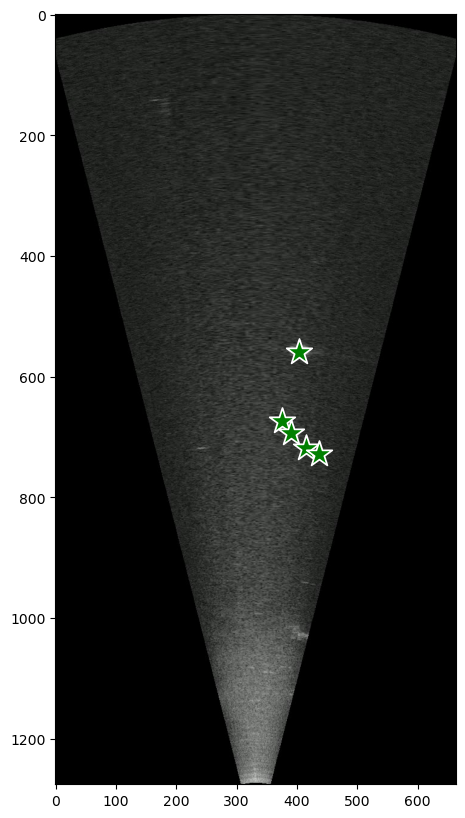

In [128]:
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# show_points(input_point, input_label, plt.gca())
# plt.axis('on')
# plt.show()



In [129]:
# masks, scores, logits = predictor.predict(
#     point_coords=input_point,
#     point_labels=input_label,
#     multimask_output=True,   
# )

In [130]:
masks.shape  # (number_of_masks) x H x W




(3, 1276, 664)

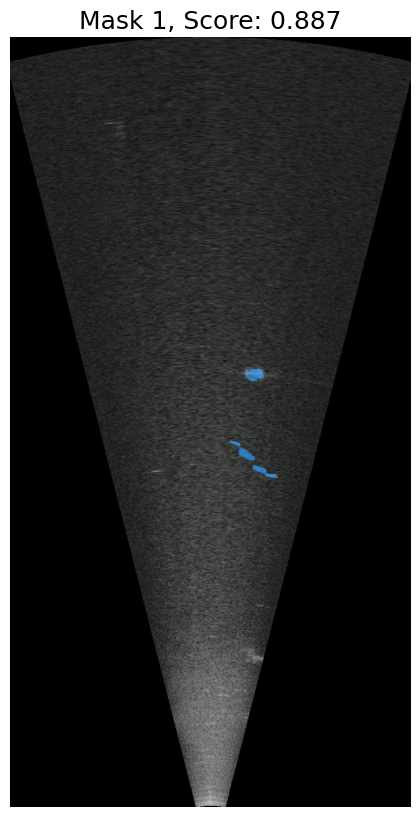

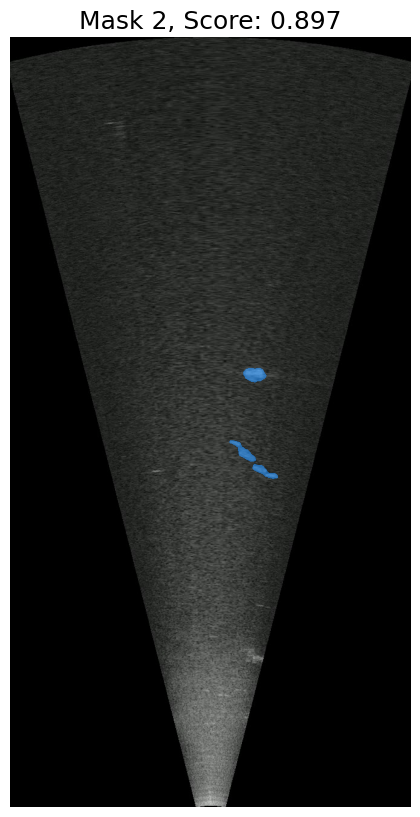

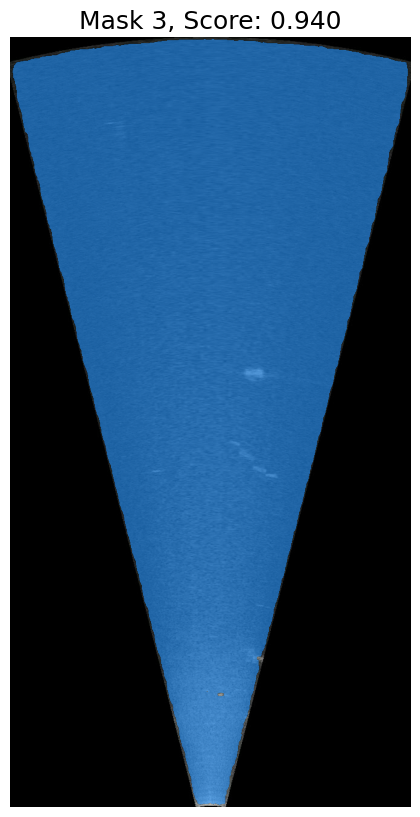

In [131]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    #show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [ ]:
plt.imshow(masks[2,:,:])
plt.show()
print(np.sum(masks[2,:,:]))

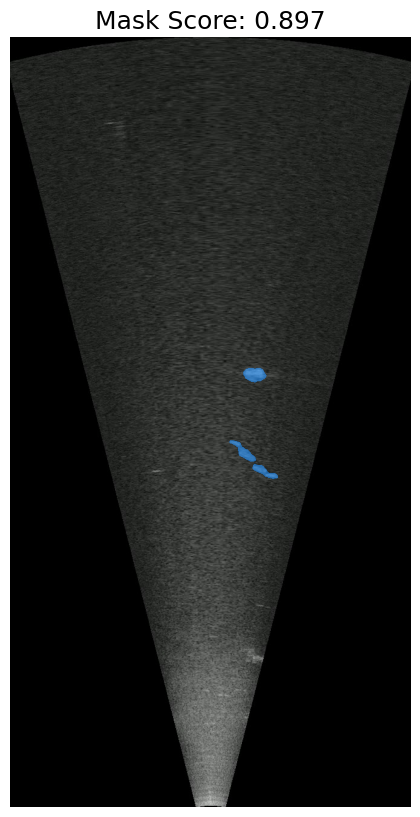

In [133]:
#460446
annotation =2
bestscore = 0

Alternative_bestscore = 0
Alternative_bestMask = 0
BestMask = 0

for i, (mask, score) in enumerate(zip(masks, scores)):

    if np.sum(mask) < 460446*0.75: # mask siwe has to be at lest 25% smaller than the precomputed triangle area, which still a very soft margin

        if bestscore < score: ## Maybe I should add an alternative best for cases in which small fishes merge together or eels are cut, and so the number of regions dont match
            BestMask = mask
            bestscore = score

        labeled_image = label(mask)
        regions = regionprops(labeled_image)
        number_of_regions = len(regions) # getting the number of objects in the segmentation

        if number_of_regions == annotation: # the segmentation has to have the same number of objects as the annotations.
            if bestscore < score:
                BestMask = mask
                bestscore =score

#I could add a closing if there are more regions than normal (eel cut) and opening if there are less (merged fish)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(BestMask, plt.gca())
#show_points(input_point, input_label, plt.gca())
plt.title(f"Mask Score: {bestscore:.3f}", fontsize=18)
plt.axis('off')
plt.show()  
            
